# Leveraging AI for Predictive Chart Pattern Analysis and Liquidity Insights: A Case Study on Bitcoin Trading Trends

pip install graphviz pandas numpy matplotlib

pip install scikit-learn pandas numpy

pip install yfinance pandas numpy

pip install seaborn pandas numpy matplotlib

pip install tensorflow 

# Generate and render the architecture for training model

In [1]:
import os
import graphviz

# Đảm bảo rằng đường dẫn đến Graphviz có trong PATH
os.environ["PATH"] += os.pathsep + r"C:\Users\Admin\Pictures\windows_10_cmake_Release_Graphviz-12.2.1-win64\Graphviz-12.2.1-win64\bin"

def create_model_architecture():
    dot = graphviz.Digraph("ML_DL_Architecture", format='png')
    
    # Tùy chỉnh kích thước và hình dạng của đồ thị
    dot.attr(rankdir='TB', size='10,15', fontname='Arial')  # TB: Top to Bottom, size: width, height, fontname: Arial
    
    # =========================
    # Các node chính
    # =========================
    
    # Database
    dot.node("DB", "Database\n(PostgreSQL + TimescaleDB)", shape='cylinder', style='filled', color='lightyellow', fontname='Arial')
    
    # Input Layer
    dot.node("Input", "Input Data\n(Market Data,\nSentiment Analysis)", 
             shape='box', style='filled', color='lightblue', fontname='Arial')
    
    # MobileNetV2, NAR, GRU
    dot.node("MobileNetV2", "MobileNetV2\n(Feature Extraction)", shape='box', style='filled', color='lightgreen', fontname='Arial')
    dot.node("NAR", "NAR\n(Non-Autoregressive)", shape='box', style='filled', color='lightgreen', fontname='Arial')
    dot.node("GRU", "GRU\n(Sequential Processing)", shape='box', style='filled', color='lightgreen', fontname='Arial')
    
    # Feature Fusion
    dot.node("Fusion", "Feature Fusion Layer", shape='box', style='filled', color='yellow', fontname='Arial')
    
    # Machine Learning Models
    dot.node("LightGBM", "LightGBM\n(Gradient Boosting)", shape='box', style='filled', color='orange', fontname='Arial')
    dot.node("XGBoost", "XGBoost\n(Gradient Boosting)", shape='box', style='filled', color='orange', fontname='Arial')
    
    # Output
    dot.node("Output", "Final Prediction\n(Price/Trend)", shape='box', style='filled', color='lightcoral', fontname='Arial')
    
    # n8n Task
    dot.node("n8n", "n8n\n(Workflow Automation)", shape='ellipse', style='filled', color='lightgrey', fontname='Arial')
    
    # Flask Task
    dot.node("Flask", "Flask\n(API Server)", shape='ellipse', style='filled', color='lightgrey', fontname='Arial')
    
    # Docker
    dot.node("Docker", "Docker\n(Containerization)", shape='ellipse', style='filled', color='lightgrey', fontname='Arial')
    
    # =========================
    # Kết nối các node
    # =========================
    
    # Database -> Input
    dot.edge("DB", "Input", label="Fetch Data", fontname='Arial')
    
    # Input -> MobileNetV2, NAR, GRU
    dot.edge("Input", "MobileNetV2")
    dot.edge("Input", "NAR")
    dot.edge("Input", "GRU")
    
    # MobileNetV2, NAR, GRU -> Fusion
    dot.edge("MobileNetV2", "Fusion")
    dot.edge("NAR", "Fusion")
    dot.edge("GRU", "Fusion")
    
    # Fusion -> LightGBM, XGBoost
    dot.edge("Fusion", "LightGBM")
    dot.edge("Fusion", "XGBoost")
    
    # LightGBM, XGBoost -> Output
    dot.edge("LightGBM", "Output")
    dot.edge("XGBoost", "Output")
    
    # Output -> n8n, Flask
    dot.edge("Output", "n8n")
    dot.edge("Output", "Flask")
    
    # Docker kết nối với n8n và Flask
    dot.edge("Docker", "n8n", label="Containerize", fontname='Arial')
    dot.edge("Docker", "Flask", label="Containerize", fontname='Arial')
    
    return dot

# Generate and render the architecture
dot = create_model_architecture()
dot.render("ML_DL_Architecture", format="png", cleanup=False)
dot.view()


'ML_DL_Architecture.png'

# Pre-processing data architecture

In [2]:
from graphviz import Digraph

# Tạo đối tượng đồ thị
dot = Digraph("PreprocessingPipeline", format="png")
dot.attr(rankdir="TB")  # Hướng từ trên xuống

# Thêm node cho các bước xử lý
dot.node("BinanceAPI", "📥 Binance API (OHLCV Data)", shape="rectangle", style="filled", fillcolor="lightblue")
dot.node("ChartPatternImages", "🖼️ Chart Pattern Images", shape="rectangle", style="filled", fillcolor="lightblue")

dot.node("PreprocessOHLCV", "🛠️ Preprocess OHLCV Data\n- Normalize Timestamp\n- Handle Missing Values", shape="rectangle", style="filled", fillcolor="lightyellow")
dot.node("ComputeIndicators", "📊 Compute Technical Indicators\n(RSI, MACD, ATR, Bollinger Bands)", shape="rectangle", style="filled", fillcolor="lightyellow")

dot.node("ExtractMobileNetV2Features", "🧠 Extract MobileNetV2 Features\n(MobileNetV2, ResNet)", shape="rectangle", style="filled", fillcolor="lightgreen")

dot.node("MergeData", "🔗 Merge Technical Indicators & MobileNetV2 Features", shape="rectangle", style="filled", fillcolor="lightcoral")

dot.node("FinalDataset", "📄 Save Final Dataset: final_dataset.csv", shape="rectangle", style="filled", fillcolor="lightgray")

# Kết nối các bước xử lý
dot.edge("BinanceAPI", "PreprocessOHLCV")

dot.edge("BinanceAPI", "ChartPatternImages")

dot.edge("PreprocessOHLCV", "ComputeIndicators")

dot.edge("ChartPatternImages", "ExtractMobileNetV2Features")

dot.edge("ComputeIndicators", "MergeData")
dot.edge("ExtractMobileNetV2Features", "MergeData")

dot.edge("MergeData", "FinalDataset")

# Xuất sơ đồ ra file
dot.render("preprocessing_pipeline", format="png", cleanup=False)
dot.view()


'preprocessing_pipeline.png'

## Environment setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import yfinance as yf
import csv


In [4]:
file_path = 'BTCUSDT.csv'  # Đường dẫn tới file của bạn

with open(file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)  # Đọc file dưới dạng từ điển
    data = list(reader)  # Chuyển thành danh sách các hàng

# Chuyển đổi danh sách từ điển thành DataFrame
df = pd.DataFrame(data)

In [5]:
print(df.head())  # Xem 5 dòng đầu

    symbol            timestamp      open      high       low     close  \
0  BTCUSDT  2024-09-01 00:00:00   58974.0   58978.0  58957.01   58978.0   
1  BTCUSDT  2024-09-01 00:05:00   58978.0  59035.76  58975.41  59035.76   
2  BTCUSDT  2024-09-01 00:10:00  59035.75   59055.0   59023.0  59038.12   
3  BTCUSDT  2024-09-01 00:15:00  59038.11  59076.59   59024.0   59024.0   
4  BTCUSDT  2024-09-01 00:20:00   59024.0   59024.0   58991.1   58991.1   

     volume  
0  15.92811  
1  65.12076  
2  25.99014  
3  20.25307  
4  18.29866  


## Preproceeding Data

Market data

In [6]:
# Chuyển đổi các cột số từ chuỗi sang dạng số thực (nếu cần)
numeric_columns = ['open', 'high', 'low', 'close', 'volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển đổi và xử lý lỗi nếu có

# 1. Chuyển đổi timestamp thành datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 2. Đổi tên cột
df.rename(columns={"Taker buy base asset volume": "taker_buy_volume"}, inplace=True)

# 3. Thêm cột mới (sự thay đổi giá giữa open và close)
df['price_change'] = df['close'] - df['open']

# 4. Xử lý dữ liệu lớn (chuẩn hóa volume)
df['volume_normalized'] = df['volume'] / df['volume'].max()

# In kết quả DataFrame đã xử lý
print(df.head())  # Xem 5 dòng đầu

    symbol           timestamp      open      high       low     close  \
0  BTCUSDT 2024-09-01 00:00:00  58974.00  58978.00  58957.01  58978.00   
1  BTCUSDT 2024-09-01 00:05:00  58978.00  59035.76  58975.41  59035.76   
2  BTCUSDT 2024-09-01 00:10:00  59035.75  59055.00  59023.00  59038.12   
3  BTCUSDT 2024-09-01 00:15:00  59038.11  59076.59  59024.00  59024.00   
4  BTCUSDT 2024-09-01 00:20:00  59024.00  59024.00  58991.10  58991.10   

     volume  price_change  volume_normalized  
0  15.92811          4.00           0.002911  
1  65.12076         57.76           0.011902  
2  25.99014          2.37           0.004750  
3  20.25307        -14.11           0.003702  
4  18.29866        -32.90           0.003344  


# ● Visualize data close price

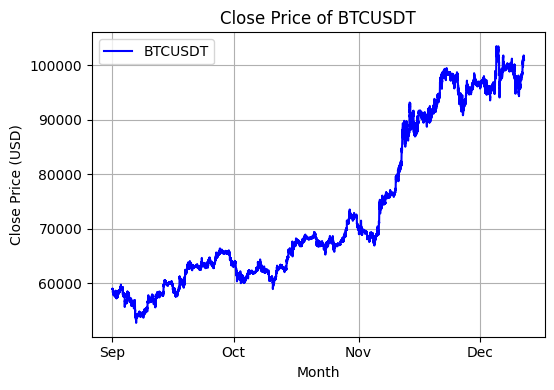

In [7]:
import math
import matplotlib.dates as mdates  # Import mdates for date formatting
# 1️⃣ Define the number of coins to display
num_coins = len(df['symbol'].unique())
num_rows = math.ceil(num_coins / 3)  # Arrange in 3 columns

# 2️⃣ Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()

# 3️⃣ Plot each coin in a separate subplot
for i, coin in enumerate(df['symbol'].unique()):
    coin_data = df[df['symbol'] == coin]
    axes[i].plot(coin_data['timestamp'], coin_data['close'], label=coin, color='b')

    # Format x-axis to show only months
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Example: "Jan", "Feb", "Mar"
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Set tick interval to months

    axes[i].set_title(f"Close Price of {coin}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Close Price (USD)")
    axes[i].grid(True)
    axes[i].legend()

# 4️⃣ Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Detect Outliers

- Compute First-Order Difference for Each Coin: (Hiệu sai bậc nhất) là cách tính sự thay đổi giữa giá trị hiện tại và giá trị trước đó trong một dãy số liệu.

Positive values → Price increased compared to the previous timestamp.

Negative values → Price dropped from the previous timestamp.

Spikes → Can indicate volatility or important market events.

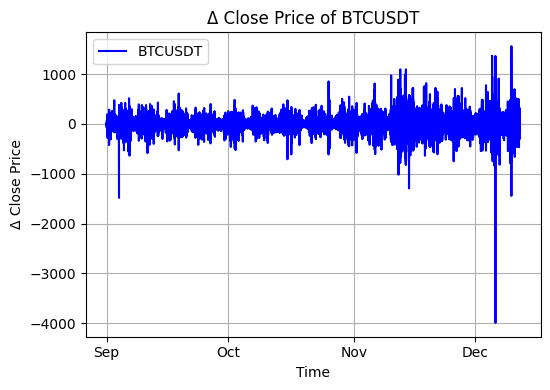

In [8]:
import math

# 1️⃣ Compute first-order difference for each coin
df['first_order_diff'] = df.groupby('symbol')['close'].diff()

# 2️⃣ Define subplot layout (3 columns)
num_coins = len(df['symbol'].unique())
num_rows = math.ceil(num_coins / 3)  # Arrange subplots in 3 columns

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()

# 3️⃣ Plot each coin's first-order difference in a separate subplot
for i, coin in enumerate(df['symbol'].unique()):
    coin_data = df[df['symbol'] == coin]
    
    axes[i].plot(coin_data['timestamp'], coin_data['first_order_diff'], label=coin, color='b')
    axes[i].set_title(f"Δ Close Price of {coin}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Δ Close Price")
    axes[i].grid(True)
    axes[i].legend()

    # Format x-axis to show only months
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Example: "Jan", "Feb", "Mar"
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Set tick interval to months

# 4️⃣ Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


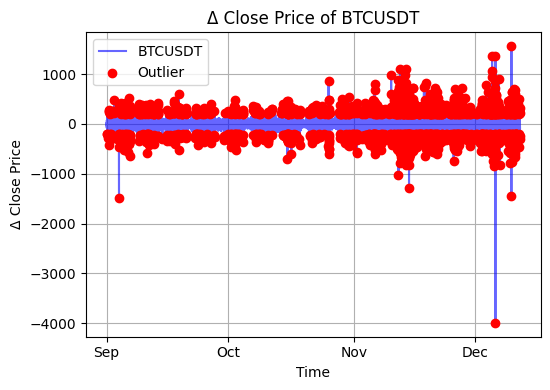

Outliers detected:
        symbol           timestamp       open       high        low  \
25     BTCUSDT 2024-09-01 02:05:00   58822.99   58823.00   58542.07   
28     BTCUSDT 2024-09-01 02:20:00   58648.00   58648.00   58445.88   
64     BTCUSDT 2024-09-01 05:20:00   58334.01   58334.01   58050.00   
166    BTCUSDT 2024-09-01 13:50:00   57809.00   58206.00   57710.00   
170    BTCUSDT 2024-09-01 14:10:00   57943.00   57943.01   57201.00   
...        ...                 ...        ...        ...        ...   
29335  BTCUSDT 2024-12-11 20:35:00  101224.18  101446.75  101195.37   
29341  BTCUSDT 2024-12-11 21:05:00  101139.28  101147.98  100888.90   
29346  BTCUSDT 2024-12-11 21:30:00  100959.41  101280.57  100950.21   
29353  BTCUSDT 2024-12-11 22:05:00  101614.00  101876.92  101605.01   
29354  BTCUSDT 2024-12-11 22:10:00  101839.99  101888.00  101529.41   

           close     volume  price_change  volume_normalized  first_order_diff  
25      58614.00  231.62089       -208.99      

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

# 1️⃣ Compute first-order difference for each coin
df['first_order_diff'] = df.groupby('symbol')['close'].diff()

# 2️⃣ Tính IQR cho từng coin
outliers = []

for coin in df['symbol'].unique():
    coin_data = df[df['symbol'] == coin]
    
    Q1 = np.percentile(coin_data['first_order_diff'].dropna(), 25)  # Q1
    Q3 = np.percentile(coin_data['first_order_diff'].dropna(), 75)  # Q3
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Đánh dấu outliers
    coin_outliers = coin_data[(coin_data['first_order_diff'] < lower_bound) | 
                              (coin_data['first_order_diff'] > upper_bound)]
    
    outliers.append(coin_outliers)

# Gộp tất cả outliers vào một DataFrame
outliers_df = pd.concat(outliers)

# 3️⃣ Define subplot layout (3 columns)
num_coins = len(df['symbol'].unique())
num_rows = math.ceil(num_coins / 3)  # Arrange subplots in 3 columns

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()

# 4️⃣ Plot each coin's first-order difference in a separate subplot
for i, coin in enumerate(df['symbol'].unique()):
    coin_data = df[df['symbol'] == coin]
    coin_outliers = outliers_df[outliers_df['symbol'] == coin]  # Lấy outliers của coin hiện tại

    axes[i].plot(coin_data['timestamp'], coin_data['first_order_diff'], label=coin, color='b', alpha=0.6)
    
    # Đánh dấu outliers bằng chấm đỏ
    axes[i].scatter(coin_outliers['timestamp'], coin_outliers['first_order_diff'], color='red', label="Outlier", zorder=3)
    
    axes[i].set_title(f"Δ Close Price of {coin}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Δ Close Price")
    axes[i].grid(True)
    axes[i].legend()

    # Format x-axis to show only months
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Example: "Jan", "Feb", "Mar"
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Set tick interval to months

# 5️⃣ Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 6️⃣ In ra danh sách outliers
print("Outliers detected:")
print(outliers_df)


In [10]:
import pandas as pd
import numpy as np

# Lọc dữ liệu của Bitcoin (BTC)
btc_data = df[df['symbol'] == 'BTCUSDT'].copy()

# Tổng số điểm dữ liệu của BTC
total_points = len(btc_data)

# Tính IQR để phát hiện outliers
Q1 = np.percentile(btc_data['first_order_diff'].dropna(), 25)  # Q1
Q3 = np.percentile(btc_data['first_order_diff'].dropna(), 75)  # Q3
IQR = Q3 - Q1

# Ngưỡng phát hiện outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc các outliers
outliers_btc = btc_data[(btc_data['first_order_diff'] < lower_bound) | 
                        (btc_data['first_order_diff'] > upper_bound)]

# Số lượng outliers
num_outliers = len(outliers_btc)

# Số điểm còn lại sau khi loại bỏ outliers
final_points = total_points - num_outliers

# Phần trăm outliers
percentage = (num_outliers / total_points) * 100

# In kết quả
print(f"Bitcoin (BTC) - Total Points: {total_points}")
print(f"Outliers: {num_outliers}")
print(f"Final Points: {final_points}")
print(f"Percentage of Outliers: {percentage:.2f}%")


Bitcoin (BTC) - Total Points: 29377
Outliers: 2269
Final Points: 27108
Percentage of Outliers: 7.72%


# Analyze the seasonality

- Tạo boxplot 
Biểu đồ hộp (Box plot) hay còn gọi là biểu đồ hộp và râu (Box and whisker plot) là biểu đồ diễn tả 5 vị trí phân bố của dữ liệu, đó là: giá trị nhỏ nhất (min), tứ phân vị thứ nhất (Q1), trung vị (median), tứ phân vị thứ 3 (Q3) và giá trị lớn nhất (max).

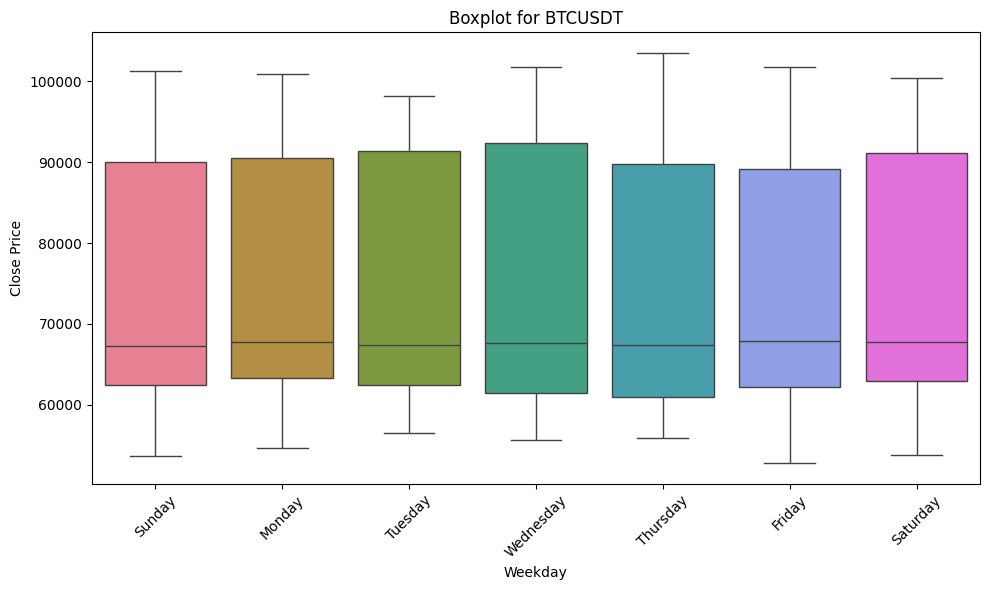

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Tạo cột Weekday_Name nếu chưa có
df['Weekday_Name'] = df['timestamp'].dt.strftime('%A')

# Drop NaN values (đặc biệt ở cột 'close' và 'Weekday_Name')
df.dropna(subset=['close', 'Weekday_Name'], inplace=True)

# Lấy coin đầu tiên trong danh sách
first_coin = df['symbol'].unique()[0]

# Lọc dữ liệu của coin đầu tiên
coin_data = df[df['symbol'] == first_coin]

# Vẽ Boxplot cho coin đầu tiên, chuyển 'Weekday_Name' vào hue và tắt legend
plt.figure(figsize=(10,6))
sns.boxplot(data=coin_data, x='Weekday_Name', y='close', hue='Weekday_Name', palette='husl', showfliers=False, dodge=False)
plt.title(f'Boxplot for {first_coin}')
plt.xlabel('Weekday')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Tắt legend
plt.tight_layout()
plt.show()


# Candlestick chart pattern

C:\Users\Admin\AppData\Local\Temp\ipykernel_12208\1128570480.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")


<Figure size 1200x600 with 0 Axes>

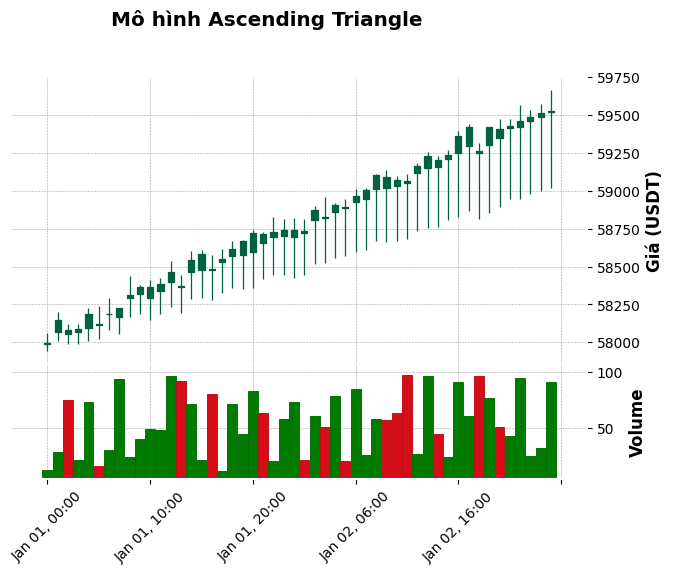

In [12]:
import mplfinance as mpf

# Tạo dữ liệu mô phỏng mô hình Ascending Triangle

# Số lượng nến
num_candles = 50  
timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")

# Tạo giá mở cửa với xu hướng tăng nhẹ
open_prices = np.linspace(58000, 59500, num_candles) + np.random.uniform(-50, 50, num_candles)

# Định nghĩa mức kháng cự cố định (đỉnh tam giác)
resistance_level = 59700

# Giá cao dao động gần mức kháng cự
high_prices = np.minimum(open_prices + np.random.uniform(50, 150, num_candles), resistance_level)

# Giá thấp tăng dần (tạo đáy cao hơn)
low_prices = open_prices - np.linspace(50, 500, num_candles) 

# Giá đóng cửa dao động giữa open và high
close_prices = np.random.uniform(open_prices, high_prices, num_candles)

# Tạo volume ngẫu nhiên
volumes = np.random.uniform(10, 100, num_candles)

# Tạo DataFrame
ascending_triangle_df = pd.DataFrame({
    "open": open_prices,
    "high": high_prices,
    "low": low_prices,
    "close": close_prices,
    "volume": volumes
}, index=timestamps)

# Vẽ biểu đồ nến cho mô hình Ascending Triangle
plt.figure(figsize=(12,6))
mpf.plot(ascending_triangle_df, type="candle", style="charles", title="Mô hình Ascending Triangle", ylabel="Giá (USDT)", volume=True)
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12208\4096810486.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")


<Figure size 1200x600 with 0 Axes>

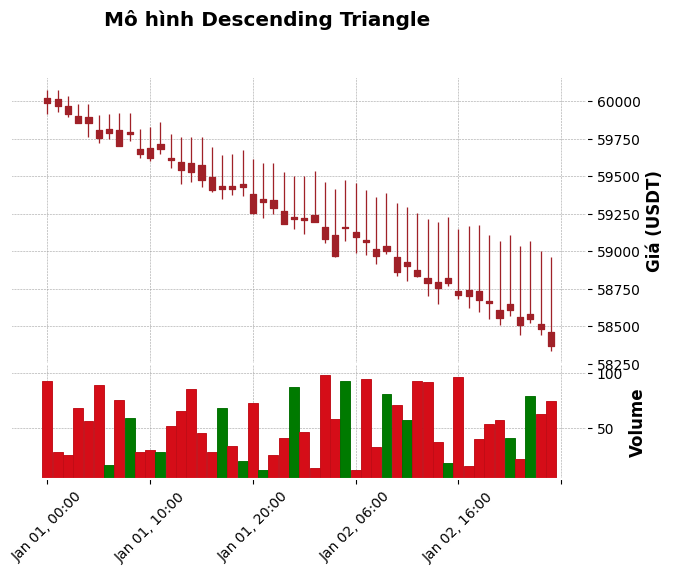

In [13]:
# Tạo dữ liệu mô phỏng mô hình Descending Triangle

# Số lượng nến
num_candles = 50  
timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")

# Tạo giá mở cửa với xu hướng giảm nhẹ
open_prices = np.linspace(60000, 58500, num_candles) + np.random.uniform(-50, 50, num_candles)

# Định nghĩa mức hỗ trợ cố định (đáy tam giác)
support_level = 58200

# Giá thấp dao động gần mức hỗ trợ
low_prices = np.maximum(open_prices - np.random.uniform(50, 150, num_candles), support_level)

# Giá cao giảm dần (tạo đỉnh thấp hơn)
high_prices = open_prices + np.linspace(50, 500, num_candles) 

# Giá đóng cửa dao động giữa open và low
close_prices = np.random.uniform(low_prices, open_prices, num_candles)

# Tạo volume ngẫu nhiên
volumes = np.random.uniform(10, 100, num_candles)

# Tạo DataFrame
descending_triangle_df = pd.DataFrame({
    "open": open_prices,
    "high": high_prices,
    "low": low_prices,
    "close": close_prices,
    "volume": volumes
}, index=timestamps)

# Vẽ biểu đồ nến cho mô hình Descending Triangle
plt.figure(figsize=(12,6))
mpf.plot(descending_triangle_df, type="candle", style="charles", title="Mô hình Descending Triangle", ylabel="Giá (USDT)", volume=True)
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12208\492506748.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")


<Figure size 1200x600 with 0 Axes>

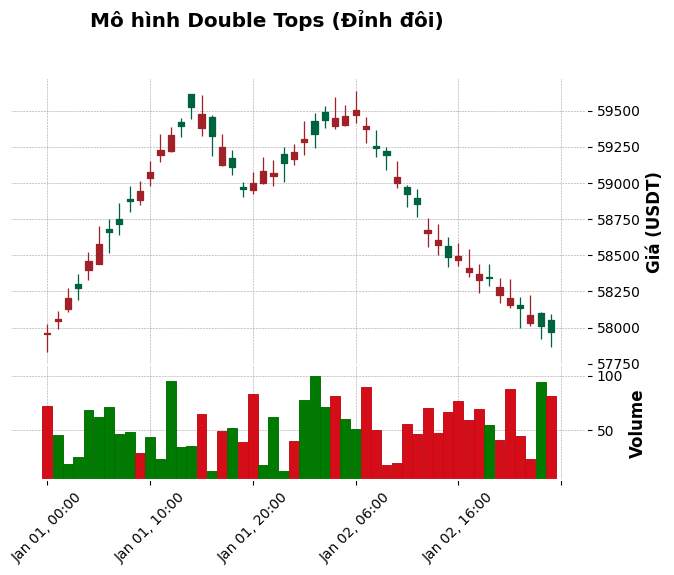

<Figure size 1200x600 with 0 Axes>

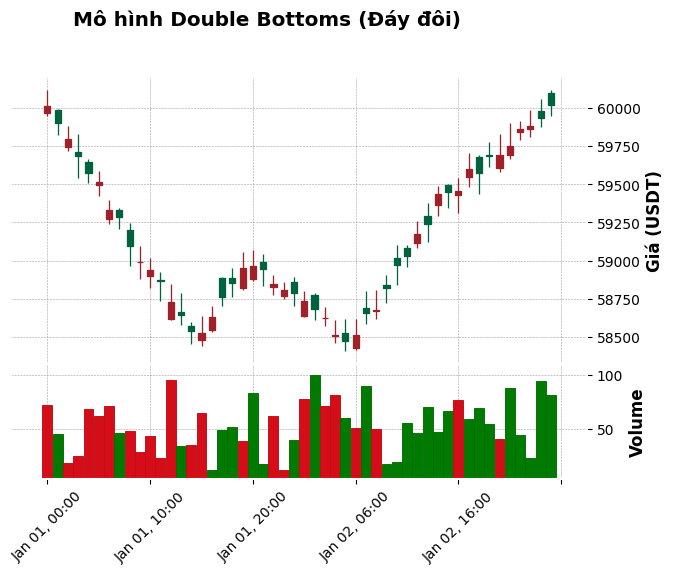

In [14]:
# Tạo dữ liệu mô phỏng mô hình Double Tops & Double Bottoms

# Số lượng nến
num_candles = 50  
timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")

# Tạo dữ liệu cho Double Tops (Đỉnh đôi)
double_tops_prices = np.concatenate([
    np.linspace(58000, 59500, 15),  # Xu hướng tăng
    np.linspace(59500, 59000, 5),   # Giảm nhẹ
    np.linspace(59000, 59500, 10),  # Lên lại tạo đỉnh đôi
    np.linspace(59500, 58500, 10),  # Giảm xuống mạnh
    np.linspace(58500, 58000, 10)   # Xu hướng giảm tiếp tục
])

# Tạo dữ liệu cho Double Bottoms (Đáy đôi)
double_bottoms_prices = np.concatenate([
    np.linspace(60000, 58500, 15),  # Xu hướng giảm
    np.linspace(58500, 59000, 5),   # Tăng nhẹ
    np.linspace(59000, 58500, 10),  # Giảm lại tạo đáy đôi
    np.linspace(58500, 59500, 10),  # Tăng mạnh
    np.linspace(59500, 60000, 10)   # Xu hướng tăng tiếp tục
])

# Tạo giá Open, High, Low, Close
open_prices = double_tops_prices + np.random.uniform(-50, 50, num_candles)
high_prices = open_prices + np.random.uniform(50, 150, num_candles)
low_prices = open_prices - np.random.uniform(50, 150, num_candles)
close_prices = np.random.uniform(low_prices, high_prices, num_candles)
volumes = np.random.uniform(10, 100, num_candles)

# Tạo DataFrame
double_tops_df = pd.DataFrame({"open": open_prices, "high": high_prices, "low": low_prices, "close": close_prices, "volume": volumes}, index=timestamps)
double_bottoms_df = double_tops_df.copy()
double_bottoms_df["open"] = double_bottoms_prices + np.random.uniform(-50, 50, num_candles)
double_bottoms_df["high"] = double_bottoms_df["open"] + np.random.uniform(50, 150, num_candles)
double_bottoms_df["low"] = double_bottoms_df["open"] - np.random.uniform(50, 150, num_candles)
double_bottoms_df["close"] = np.random.uniform(double_bottoms_df["low"], double_bottoms_df["high"], num_candles)

# Vẽ biểu đồ nến cho Double Tops
plt.figure(figsize=(12,6))
mpf.plot(double_tops_df, type="candle", style="charles", title="Mô hình Double Tops (Đỉnh đôi)", ylabel="Giá (USDT)", volume=True)
plt.show()

# Vẽ biểu đồ nến cho Double Bottoms
plt.figure(figsize=(12,6))
mpf.plot(double_bottoms_df, type="candle", style="charles", title="Mô hình Double Bottoms (Đáy đôi)", ylabel="Giá (USDT)", volume=True)
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12208\1556679502.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12208\1556679502.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_center = (df['high'][advance_block_index] + df['low'][advance_block_index + 2]) / 2


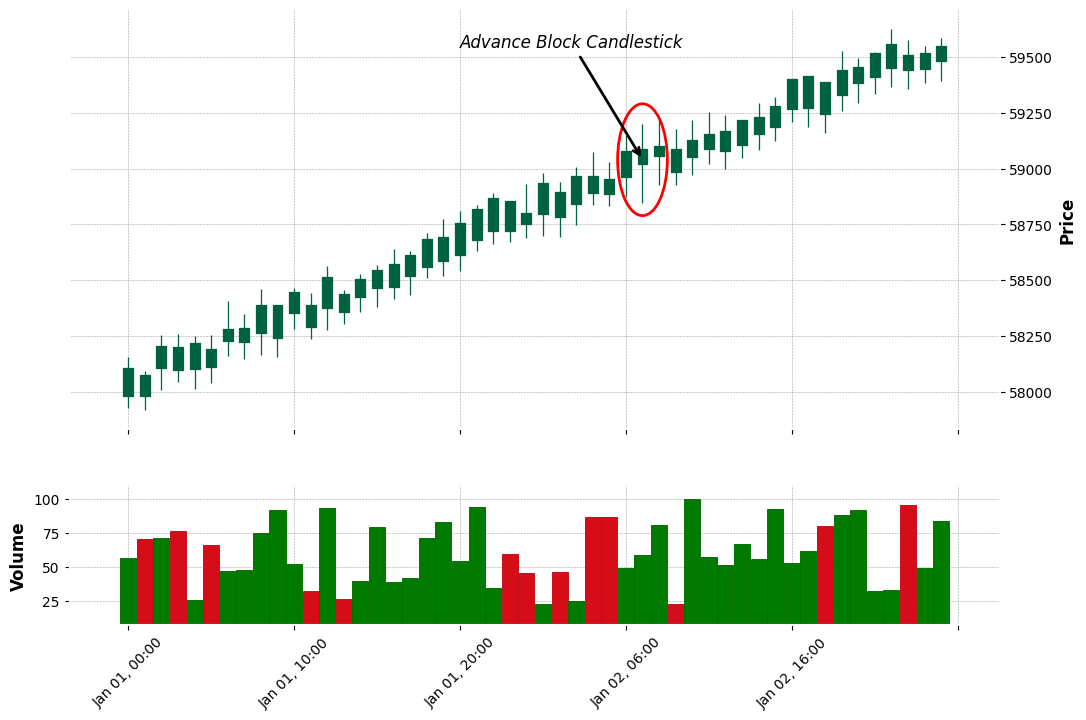

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from matplotlib.patches import Ellipse

# 🔹 Tạo dữ liệu mô phỏng xu hướng tăng
num_candles = 50
timestamps = pd.date_range(start="2024-01-01", periods=num_candles, freq="H")

# Giá mở cửa tăng dần
open_prices = np.linspace(58000, 59500, num_candles) + np.random.uniform(-50, 50, num_candles)

# Giá cao hơn tạo bóng trên dài
high_prices = open_prices + np.random.uniform(100, 200, num_candles)

# Giá thấp dao động (đảm bảo xu hướng tăng)
low_prices = open_prices - np.random.uniform(50, 100, num_candles)

# Giá đóng cửa tăng dần nhưng có một số nến giảm
close_prices = open_prices + np.random.uniform(50, 150, num_candles)

# 📌 **Tạo 3 nến Advance Block**
advance_block_index = 30  # Bắt đầu từ nến 30

# 🔹 Nến 1: Tăng mạnh, thân dài
open_prices[advance_block_index] = open_prices[advance_block_index - 1] + np.random.uniform(50, 100)
close_prices[advance_block_index] = open_prices[advance_block_index] + np.random.uniform(100, 150)
high_prices[advance_block_index] = close_prices[advance_block_index] + np.random.uniform(50, 100)

# 🔹 Nến 2: Tăng nhưng thân ngắn hơn 70% so với nến 1, bóng trên dài
open_prices[advance_block_index + 1] = np.random.uniform(open_prices[advance_block_index], close_prices[advance_block_index])
close_prices[advance_block_index + 1] = open_prices[advance_block_index + 1] + (close_prices[advance_block_index] - open_prices[advance_block_index]) * np.random.uniform(0.5, 0.7)
high_prices[advance_block_index + 1] = close_prices[advance_block_index + 1] + np.random.uniform(100, 150)

# 🔹 Nến 3: Tăng nhưng thân nhỏ hơn nến 2, bóng trên dài
open_prices[advance_block_index + 2] = np.random.uniform(open_prices[advance_block_index + 1], close_prices[advance_block_index + 1])
close_prices[advance_block_index + 2] = open_prices[advance_block_index + 2] + (close_prices[advance_block_index + 1] - open_prices[advance_block_index + 1]) * np.random.uniform(0.5, 0.7)
high_prices[advance_block_index + 2] = close_prices[advance_block_index + 2] + np.random.uniform(100, 150)

# Tạo volume ngẫu nhiên
volumes = np.random.uniform(20, 100, num_candles)

# 🔹 Xây dựng DataFrame
df = pd.DataFrame({
    "open": open_prices,
    "high": high_prices,
    "low": low_prices,
    "close": close_prices,
    "volume": volumes
}, index=timestamps)

# 📌 **Tạo figure và hai trục**
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# 🔹 Vẽ biểu đồ nến
mpf.plot(df, type='candle', style='charles', ax=ax1, volume=ax2)

# 📌 **Đánh dấu mô hình Advance Block**
x_center = timestamps[advance_block_index + 1]
y_center = (df['high'][advance_block_index] + df['low'][advance_block_index + 2]) / 2

# Vẽ ellipse quanh mô hình
ellipse = Ellipse((advance_block_index + 1, y_center), width=3, height=500, edgecolor='red', facecolor='none', lw=2)
ax1.add_patch(ellipse)

# Vẽ mũi tên chỉ vào mô hình
ax1.annotate('Advance Block Candlestick', xy=(advance_block_index + 1, y_center), 
             xytext=(advance_block_index - 10, y_center + 500),
             arrowprops=dict(facecolor='red', arrowstyle="->", lw=2),
             fontsize=12, fontstyle='italic', color='black')

# 🔹 Hiển thị biểu đồ
plt.show()


# Chỉ báo kỹ thuật (Technical Indicators)

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Hàm tính VWAP
def compute_vwap(df):
    return (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()

# Hàm tính log return
def log_return(series, periods=1):
    return np.log(series / series.shift(periods))

# Hàm tính RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss.replace([np.inf, -np.inf], np.nan)
    return 100 - (100 / (1 + rs))

# Hàm tính chỉ báo kỹ thuật cho 1 coin và thêm các đặc trưng khác
def calculate_technical_indicators(df_coin):
    # Tính SMA và EMA 14 ngày cho giá đóng cửa
    df_coin['SMA_14'] = df_coin['close'].rolling(window=14).mean()
    df_coin['EMA_14'] = df_coin['close'].ewm(span=14, adjust=False).mean()
    
    # Tính RSI 14 ngày
    df_coin['RSI_14'] = compute_rsi(df_coin['close'], period=14)
    
    # Tính MACD và Signal Line
    short_ema = df_coin['close'].ewm(span=12, adjust=False).mean()
    long_ema = df_coin['close'].ewm(span=26, adjust=False).mean()
    df_coin['MACD'] = short_ema - long_ema
    df_coin['Signal_Line'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
    
    # Tính Bollinger Bands (dùng 20 phiên)
    rolling_mean = df_coin['close'].rolling(window=20).mean()
    rolling_std = df_coin['close'].rolling(window=20).std()
    df_coin['Bollinger_Upper'] = rolling_mean + 2 * rolling_std
    df_coin['Bollinger_Lower'] = rolling_mean - 2 * rolling_std
    
    # Tính ATR 14 ngày (sử dụng True Range)
    df_coin['TR'] = np.maximum(df_coin['high'] - df_coin['low'],
                           np.maximum(abs(df_coin['high'] - df_coin['close'].shift(1)),
                                      abs(df_coin['low'] - df_coin['close'].shift(1))))
    df_coin['ATR_14'] = df_coin['TR'].rolling(window=14).mean()
    
    # Thêm các đặc trưng liên quan đến thời gian
    df_coin['Weekday'] = df_coin['timestamp'].dt.dayofweek    # 0 = Monday, 6 = Sunday
    df_coin['Hour'] = df_coin['timestamp'].dt.hour
    
    # Các đặc trưng liên quan đến nến
    df_coin['body_size'] = (df_coin['close'] - df_coin['open']).abs()       # Kích thước thân nến
    df_coin['candle_range'] = df_coin['high'] - df_coin['low']                # Toàn bộ phạm vi của nến
    df_coin['body_ratio'] = df_coin['body_size'] / df_coin['candle_range']      # Tỷ lệ thân nến so với toàn bộ
    
    # Đặc trưng khối lượng
    df_coin['volume_mean_20'] = df_coin['volume'].rolling(window=20).mean()
    df_coin['volume_ratio'] = df_coin['volume'] / df_coin['volume_mean_20']
    
    # Tính VWAP
    df_coin['vwap'] = compute_vwap(df_coin)
    
     # Target column: Residualized return trong 15 phút tới
    df_coin['log_return_15min'] = log_return(df_coin['close'], periods=15)
    df_coin['SMA_return_15min'] = df_coin['log_return_15min'].rolling(window=15).mean()
    df_coin['target_residual'] = df_coin['log_return_15min'] - df_coin['SMA_return_15min']

    
    # Loại bỏ các dòng có giá trị NaN do quá trình tính toán
    return df_coin.dropna()


In [17]:
# Đọc dữ liệu, parse cột timestamp
df = pd.read_csv('BTCUSDT.csv', parse_dates=['timestamp'])

# Lọc dữ liệu của coin BTC (giả sử cột 'symbol' có chứa mã coin)
df_btc = df[df['symbol'] == 'BTCUSDT']

# Tính các chỉ báo kỹ thuật và các đặc trưng cho coin BTC
df_btc_technical = calculate_technical_indicators(df_btc)

# Hiển thị 5 dòng đầu của DataFrame sau khi tính chỉ báo
print(df_btc_technical.head())

     symbol           timestamp      open      high       low     close  \
29  BTCUSDT 2024-09-01 02:25:00  58445.87  58445.87  58280.00  58315.00   
30  BTCUSDT 2024-09-01 02:30:00  58314.99  58441.51  58276.01  58435.00   
31  BTCUSDT 2024-09-01 02:35:00  58435.00  58520.78  58428.00  58504.01   
32  BTCUSDT 2024-09-01 02:40:00  58504.00  58560.18  58470.50  58480.00   
33  BTCUSDT 2024-09-01 02:45:00  58480.00  58490.00  58429.47  58440.00   

       volume        SMA_14        EMA_14     RSI_14  ...  Hour  body_size  \
29  148.71864  58754.475714  58692.505033   9.718769  ...     2     130.87   
30  146.98020  58718.832857  58658.171029  20.711150  ...     2     120.01   
31   79.11355  58688.976429  58637.616225  27.004962  ...     2      69.01   
32   75.08041  58658.976429  58616.600728  26.945372  ...     2      24.00   
33   38.87876  58628.357143  58593.053965  26.691316  ...     2      40.00   

    candle_range  body_ratio  volume_mean_20  volume_ratio          vwap  \
29  

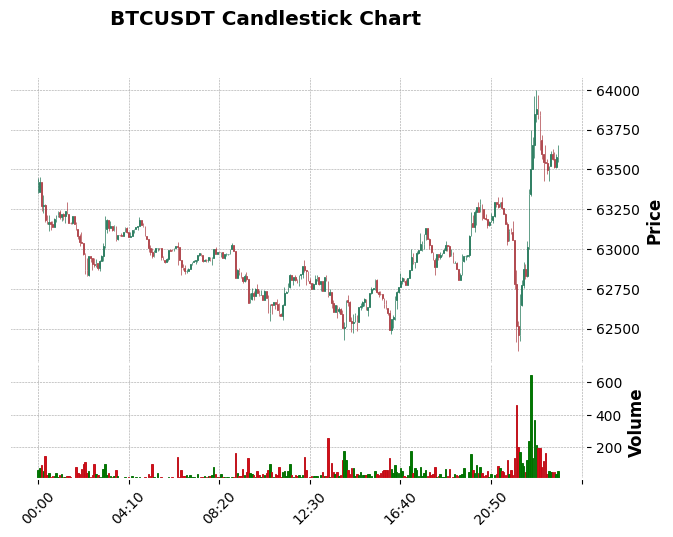

In [18]:
import pandas as pd
import mplfinance as mpf

# Đọc dữ liệu từ tệp CSV
file_path = 'BTCUSDT.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'])

# Đảm bảo dữ liệu có các cột cần thiết: 'timestamp', 'open', 'high', 'low', 'close', 'volume'
df.set_index('timestamp', inplace=True)

# Chọn khoảng thời gian để vẽ biểu đồ (nếu cần)
start_date = '2024-09-22'
end_date = '2024-09-22'
df = df.loc[start_date:end_date]

# Vẽ biểu đồ nến
mpf.plot(df, type='candle', volume=True, style='charles', title='BTCUSDT Candlestick Chart', ylabel='Price', ylabel_lower='Volume')

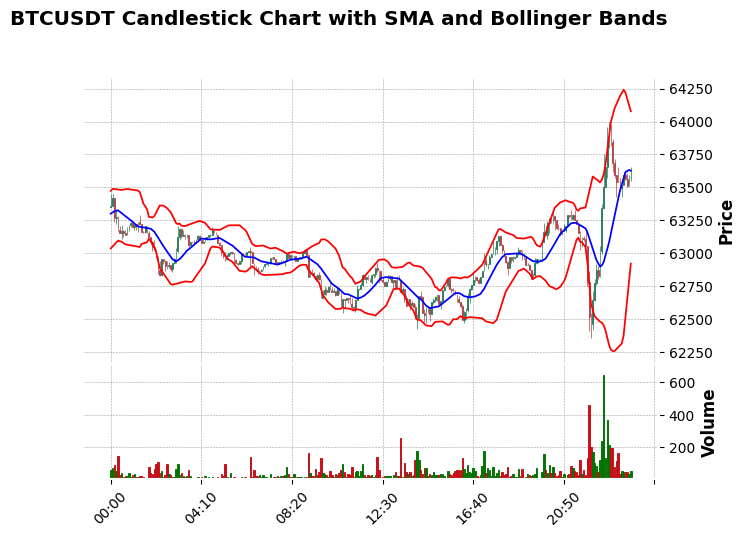

In [19]:
import pandas as pd
import mplfinance as mpf

# Đọc dữ liệu từ tệp CSV
file_path = 'BTCUSDT.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'])

# Đảm bảo dữ liệu có các cột cần thiết: 'timestamp', 'open', 'high', 'low', 'close', 'volume'
df.set_index('timestamp', inplace=True)

# Tính chỉ báo SMA
df['SMA_14'] = df['close'].rolling(window=14).mean()

# Tính chỉ báo Bollinger Bands
df['BB_Middle'] = df['close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['close'].rolling(window=20).std()

# Chọn khoảng thời gian để vẽ biểu đồ (nếu cần)
start_date = '2024-09-22'
end_date = '2024-09-22'
df = df.loc[start_date:end_date]

# Tạo các đối tượng addplot cho SMA và Bollinger Bands
apds = [
    mpf.make_addplot(df['SMA_14'], color='blue'),
    mpf.make_addplot(df['BB_Upper'], color='red'),
    mpf.make_addplot(df['BB_Lower'], color='red')
]

# Vẽ biểu đồ nến với chỉ báo SMA và Bollinger Bands
mpf.plot(df, type='candle', volume=True, style='charles', title='BTCUSDT Candlestick Chart with SMA and Bollinger Bands',
         ylabel='Price', ylabel_lower='Volume', addplot=apds)

# Visualization 

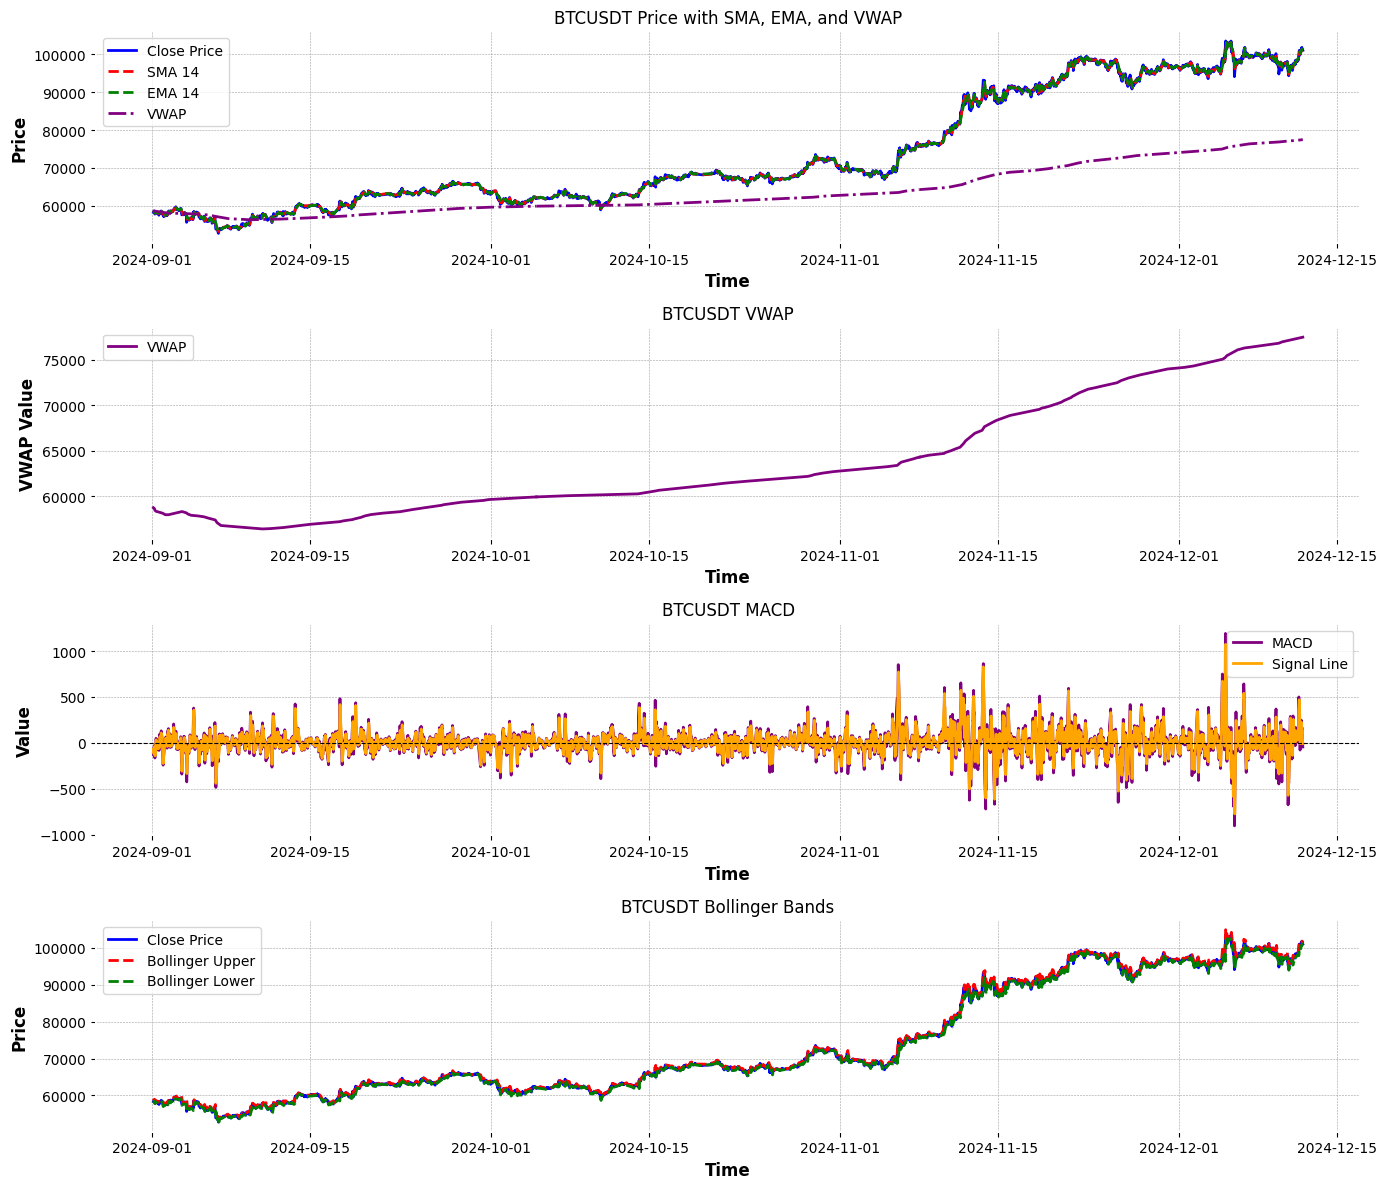

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))

# Biểu đồ giá đóng cửa + SMA, EMA, VWAP
plt.subplot(4, 1, 1)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['close'], label='Close Price', color='blue')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['SMA_14'], label='SMA 14', color='red', linestyle='--')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['EMA_14'], label='EMA 14', color='green', linestyle='--')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['vwap'], label='VWAP', color='purple', linestyle='-.')
plt.title('BTCUSDT Price with SMA, EMA, and VWAP')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Biểu đồ VWAP riêng biệt
plt.subplot(4, 1, 2)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['vwap'], label='VWAP', color='purple')
plt.title('BTCUSDT VWAP')
plt.xlabel('Time')
plt.ylabel('VWAP Value')
plt.legend()
plt.grid(True)

# Biểu đồ MACD với đường 0
plt.subplot(4, 1, 3)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['MACD'], label='MACD', color='purple')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['Signal_Line'], label='Signal Line', color='orange')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Thêm đường 0
plt.title('BTCUSDT MACD')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Biểu đồ Bollinger Bands với vùng bóng mờ
plt.subplot(4, 1, 4)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['close'], label='Close Price', color='blue')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['Bollinger_Upper'], label='Bollinger Upper', color='red', linestyle='--')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['Bollinger_Lower'], label='Bollinger Lower', color='green', linestyle='--')
plt.fill_between(df_btc_technical['timestamp'], df_btc_technical['Bollinger_Lower'], df_btc_technical['Bollinger_Upper'], color='gray', alpha=0.3)  # Bóng mờ
plt.title('BTCUSDT Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Using MobileNetV2

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import mlflow
import mlflow.keras
from sklearn.preprocessing import MultiLabelBinarizer

def create_model(num_classes):
    """Xây dựng mô hình transfer learning với MobileNetV2 cho bài toán multi-label."""
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model.trainable = False  # Đóng băng base model ban đầu
    inputs = Input(shape=(224,224,3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    return model

# 1. Đọc file CSV chứa nhãn (CSV có cột "image_name" và "label")
label_csv = "crypto_chart_patterns_labels_merged.csv"
df_labels = pd.read_csv(label_csv)

# 2. Chuyển đổi nhãn từ chuỗi sang danh sách và sử dụng MultiLabelBinarizer
df_labels['label_list'] = df_labels['label'].apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df_labels['label_list'])
num_classes = len(mlb.classes_)
print("Số lớp (classes) multi-label:", num_classes)

# 3. Chuyển vector nhị phân thành DataFrame với mỗi cột cho một nhãn
mlb_df = pd.DataFrame(binary_labels, columns=mlb.classes_)

# 4. Nối DataFrame nhãn mới vào df_labels
df_labels = pd.concat([df_labels, mlb_df], axis=1)

# 5. Thiết lập ImageDataGenerator với MobileNetV2 preprocess
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Danh sách các cột nhãn (được tạo từ MultiLabelBinarizer)
label_columns = mlb.classes_.tolist()

# 6. Tạo generator cho tập training
train_generator = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=".",                # CSV chứa đường dẫn đầy đủ đến ảnh, ví dụ: "crypto_chart_patterns/chart_0.png"
    x_col="image_name",
    y_col=label_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="training"
)

# 7. Tạo generator cho tập validation
validation_generator = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=".",
    x_col="image_name",
    y_col=label_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="validation"
)

# 8. Xây dựng và biên dịch mô hình
model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Lưu trọng số ban đầu của mô hình để có thể reset lại sau này
initial_weights = model.get_weights()

# 9. Thiết lập callbacks: EarlyStopping và ReduceLROnPlateau
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# 10. Huấn luyện mô hình và log qua MLFlow
with mlflow.start_run():
    # Log các tham số
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 50)
    mlflow.log_param("target_size", (224, 224))
    mlflow.log_param("rotation_range", 15)
    mlflow.log_param("width_shift_range", 0.1)
    mlflow.log_param("height_shift_range", 0.1)
    mlflow.log_param("zoom_range", 0.2)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("num_classes", num_classes)
    
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stop, lr_reduce]
    )
    
    best_val_accuracy = max(history.history["val_accuracy"])
    mlflow.log_metric("best_val_accuracy", best_val_accuracy)
    
    # Log mô hình bằng mlflow.keras.log_model thay vì mlflow.tensorflow.log_model
    mlflow.keras.log_model(model, artifact_path="MobileNetV2_MultiLabel")
    
    # Lưu mô hình với định dạng native của Keras
    model.save("candlestick_pattern_mobilenetv2_multilabel.keras")
    
    print("MLFlow run đã kết thúc, mô hình và các metric đã được log.")


Số lớp (classes) multi-label: 4
Found 4696 validated image filenames.
Found 1174 validated image filenames.


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 152s 995ms/step - accuracy: 0.4911 - loss: 0.1255 - val_accuracy: 0.9344 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5184 - loss: 0.0864 - val_accuracy: 0.9532 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.5033 - loss: 0.0785 - val_accuracy: 0.1576 - val_loss: 0.0688 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.4916 - loss: 0.0827 - val_accuracy: 0.9932 - val_loss: 0.0711 - learning_rate: 0.0010
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.6250 - loss: 0.0761
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
147/147 ━━━━━━━━━━━━━━━━━━━━ 131s 891ms/step - accuracy: 0.6245 - loss: 0.0761 - val_accuracy: 0.0000e+00 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 127s 867ms/step - accuracy: 0.33

2025/03/14 15:38:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/14 15:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow run đã kết thúc, mô hình và các metric đã được log.


## Evaluation Model MobileNetV2
- Trong bài toán multi-label, có nhiều cách tính "accuracy" khác nhau. Một cách tính phổ biến là subset accuracy (còn gọi là exact match ratio), nghĩa là tính tỷ lệ mẫu mà mô hình dự đoán chính xác tất cả các nhãn.
- tập val: Đây là tập dữ liệu có các trường tương tự như tập train. Chúng ta chỉ sử dụng tập này để kiểm tra kết quả dự báo của mô hình mà không đưa vào huấn luyện mô hình. Thông qua đánh giá trên tập val, các hiện tượng overfitting hoặc underfitting nghiêm trọng sẽ được phát hiện và tiến hành hiệu chỉnh.
- tập dev: Đây là tập dữ liệu có các trường cũng tương tự như tập train và val nhưng được dùng để đánh giá việc lựa chọn các siêu tham số (hyper parameters) cho các mô hình huấn luyện từ tập train.
- tập test: Đây cũng là tập dữ liệu có các trường giống train, val, dev và được coi như những quan sát mới hoàn toàn. Tập test nên có phân phối giống nhất với dữ liệu thực tế mà người dùng sẽ tạo ra để đánh giá khả năng áp dụng mô hình vào thực tiễn.

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score

# Dự đoán trên tập validation
val_preds = model.predict(validation_generator)
# Chuyển các xác suất dự đoán thành nhãn (binary) với ngưỡng 0.5
val_preds_binary = (val_preds > 0.5).astype(int)

# Lấy nhãn thực từ generator (đảm bảo thứ tự tương ứng)
val_true = validation_generator.labels

# Tính subset accuracy: mẫu nào có tất cả nhãn đúng mới được tính là chính xác
subset_accuracy = np.mean(np.all(val_preds_binary == val_true, axis=1))
print("Subset Accuracy:", subset_accuracy)


37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 692ms/step
Subset Accuracy: 0.9471890971039182


In [23]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Dự đoán trên tập validation
val_preds = model.predict(validation_generator)
# Chuyển các xác suất dự đoán thành nhãn (binary) với ngưỡng 0.5
val_preds_binary = (val_preds > 0.5).astype(int)

# Lấy nhãn thực từ generator
# Lưu ý: validation_generator.labels sẽ trả về mảng các nhãn, đảm bảo thứ tự tương ứng với val_preds
val_true = validation_generator.labels

# Nếu bạn đã sử dụng MultiLabelBinarizer, hãy lấy danh sách các nhãn (classes)
# Ví dụ: target_names = mlb.classes_
target_names = mlb.classes_  # Đảm bảo rằng mlb được định nghĩa trong quá trình tiền xử lý nhãn

# In báo cáo chi tiết cho từng nhãn
print("Classification Report:")
print(classification_report(val_true, val_preds_binary, target_names=target_names, zero_division=0))

# Tính toán các chỉ số trung bình (macro-average)
precision_macro = precision_score(val_true, val_preds_binary, average='macro', zero_division=0)
recall_macro = recall_score(val_true, val_preds_binary, average='macro', zero_division=0)
f1_macro = f1_score(val_true, val_preds_binary, average='macro', zero_division=0)

print("Precision (macro):", precision_macro)
print("Recall (macro):", recall_macro)
print("F1-score (macro):", f1_macro)


37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 672ms/step
Classification Report:
                   precision    recall  f1-score   support

Bearish_Engulfing       1.00      1.00      1.00      1172
Bullish_Engulfing       1.00      1.00      1.00      1172
             Doji       0.98      1.00      0.99      1147
           Harami       0.97      1.00      0.99      1141

        micro avg       0.99      1.00      0.99      4632
        macro avg       0.99      1.00      0.99      4632
     weighted avg       0.99      1.00      0.99      4632
      samples avg       0.99      1.00      0.99      4632

Precision (macro): 0.9863713798977853
Recall (macro): 1.0
F1-score (macro): 0.9931017984261399


## file CSV có 1,366 giá trị nhãn khác nhau (Epochs 50). 
accuracy: 0.0072 - loss: 7.0920

Validation Accuracy: 0.01

Validation Loss: 7.0950

- Giảm số lượng lớp: Xem xét nhóm các mẫu nến lại thành các nhóm chính (ví dụ: “Bullish” và “Bearish”, hoặc chỉ tập trung vào những mẫu quan trọng nhất như Hammer, Doji, Bullish Engulfing, v.v.).

- Chuyển sang bài toán multi-label: Nếu một ảnh có thể chứa nhiều mẫu nến, hãy chuyển bài toán từ multi-class sang multi-label. Thay vì có một lớp duy nhất cho mỗi sự kết hợp, bạn có thể có nhiều nhãn độc lập với nhau (ví dụ: output layer có kích thước bằng số lượng mẫu bạn quan tâm, mỗi đầu ra dùng sigmoid và sử dụng loss binary_crossentropy cho mỗi nhãn).


## Đánh giá mô hình trên tập test

In [24]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Giả sử file test của bạn chỉ có cột "image_name" và "label"
df_test = pd.read_csv("crypto_chart_patterns_labels_ADA.csv")

# Nếu file test chỉ có cột "image_name" và "label", chuyển cột "label" thành danh sách nhãn
df_test['label_list'] = df_test['label'].apply(lambda x: x.split('|'))

# Sử dụng đối tượng MultiLabelBinarizer đã được fit trên dữ liệu huấn luyện
# Giả sử bạn đã có mlb từ quá trình huấn luyện
# Nếu chưa, bạn cần tái tạo mlb dựa trên tập training, ví dụ:
# mlb = MultiLabelBinarizer().fit(df_train['label_list'])

# Áp dụng mlb để biến đổi nhãn của tập test thành dạng vector one-hot
test_binary = mlb.transform(df_test['label_list'])
test_ml_df = pd.DataFrame(test_binary, columns=mlb.classes_)

# Nối các cột one-hot vào DataFrame test
df_test = pd.concat([df_test, test_ml_df], axis=1)

# Lấy danh sách các cột nhãn (one-hot)
label_columns = mlb.classes_.tolist()

# Tạo ImageDataGenerator cho tập test (chỉ cần preprocess, không cần augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Tạo test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=".",  # Đảm bảo rằng các đường dẫn trong cột "image_name" là chính xác
    x_col="image_name",
    y_col=label_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False  # Quan trọng: giữ thứ tự mẫu
)

# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Dự đoán trên tập test
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)

# Lấy nhãn thực từ test_generator
y_true = test_generator.labels

# In báo cáo phân loại cho các nhãn
report = classification_report(y_true, y_pred_binary, target_names=mlb.classes_, zero_division=0)
print(report)


Found 2935 validated image filenames.


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9785 - loss: 0.0603
Test Loss: 0.0636
Test Accuracy: 0.9765
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 705ms/step
                   precision    recall  f1-score   support

Bearish_Engulfing       1.00      1.00      1.00      2927
Bullish_Engulfing       1.00      1.00      1.00      2927
             Doji       0.98      1.00      0.99      2866
           Harami       0.98      1.00      0.99      2879

        micro avg       0.99      1.00      0.99     11599
        macro avg       0.99      1.00      0.99     11599
     weighted avg       0.99      1.00      0.99     11599
      samples avg       0.99      1.00      0.99     11599



# Feature Extraction

In [ ]:
import pandas as pd
from tensorflow.keras.models import Model

# Chọn đầu ra của lớp Dense(128, activation="relu")
# Giả sử mô hình của bạn có cấu trúc:
# [Input, MobileNetV2, GlobalAveragePooling2D, Dense(128, activation="relu"), Dropout, Dense(num_classes, activation="sigmoid")]
# Vì vậy, đầu ra của lớp Dense(128) thường là model.layers[-3]
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Sử dụng test_generator (hoặc generator khác) để trích xuất đặc trưng
features = feature_extractor.predict(test_generator)
print("Kích thước feature vectors:", features.shape)

# Tạo DataFrame từ các feature vectors
df_features = pd.DataFrame(features)

# Nếu bạn muốn lưu tên file ảnh đi kèm, bạn có thể lấy tên ảnh từ test_generator.filenames
if hasattr(test_generator, "filenames"):
    filenames = test_generator.filenames
    df_features.insert(0, "image_name", filenames)

# Lưu DataFrame thành file CSV
output_csv = "MobileNetV2_test_features.csv"
df_features.to_csv(output_csv, index=False)
print(f"Đã lưu feature vectors vào file {output_csv}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 557ms/step
Kích thước feature vectors: (2935, 128)
Đã lưu feature vectors vào file MobileNetV2_test_features.csv


# Chuẩn bị dữ liệu để Train mô hình data csv

## 1: Xử lý dữ liệu file csv

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Hàm tạo dữ liệu chuỗi từ X và y ---
# Hàm tạo dữ liệu chuỗi với cửa sổ seq_length
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length-1])
    return np.array(X_seq), np.array(y_seq)

# --- Hàm load ảnh từ danh sách đường dẫn ---
def load_images(filenames, target_size=(224,224)):
    images = []
    for fname in filenames:
        img = load_img(fname, target_size=target_size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Đọc đặc trưng kỹ thuật từ file CSV
df_technical = pd.read_csv("BTCUSDT.csv", parse_dates=['timestamp'])

# Tính chỉ báo kỹ thuật từ df_technical
df_technical = calculate_technical_indicators(df_technical)

# Chọn tập đặc trưng kỹ thuật
features = [
    'open', 'high', 'low', 'close', 'volume', 
    'vwap', 'SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'Signal_Line', 
    'Bollinger_Upper', 'Bollinger_Lower', 'ATR_14', 
    'Weekday', 'Hour', 'body_size', 'candle_range', 'body_ratio', 'volume_ratio',
    'log_return_15min', 'SMA_return_15min', 'target_residual'
]

X_tech  = df_technical[features].values

# Chuẩn hóa đặc trưng kỹ thuật
scaler = StandardScaler()
X_tech_scaled = scaler.fit_transform(X_tech)

# Tạo nhãn mục tiêu: dự đoán log_return_15min > 0
y = (df_technical['log_return_15min'] > 0).astype(int).values

# Tạo dữ liệu chuỗi từ đặc trưng kỹ thuật (cho nhánh GRU)
seq_length = 10  # Số timesteps mỗi sequence
X_seq, y_seq = create_sequences(X_tech_scaled, y, seq_length)

# Vì dữ liệu chuỗi mất đi (seq_length-1) mẫu đầu, ta “trim” dữ liệu ban đầu:
n_trim = seq_length - 1
X_tech_aligned = X_tech_scaled[n_trim:]
y_aligned = y[n_trim:]

## Xử lý dữ liệu hình ảnh

In [59]:
# ================================
# Bước 2: Xử lý dữ liệu ảnh từ crypto_chart_patterns_labels_merged.csv
# ================================
df_labels = pd.read_csv("crypto_chart_patterns_labels_merged.csv")
# Giả sử file CSV có cột "image_name" chứa đường dẫn ảnh.
X_img = load_images(df_labels['image_name'].values, target_size=(224,224))

## Chia dữ liệu thành tập train và test

In [ ]:
# --- Bước 3: Căn chỉnh dữ liệu kỹ thuật theo số mẫu của ảnh ---
# Giả sử số mẫu của ảnh là n_img:
n_img = X_img.shape[0]
# Cắt X_tech_scaled và y để chỉ giữ lại n_img mẫu đầu tiên (giả sử dữ liệu được ghi nhận theo cùng thứ tự thời gian)
X_tech_aligned_full = X_tech_scaled[:n_img]
y_aligned_full = y[:n_img]

# --- Bước 4: Tạo dữ liệu chuỗi từ đặc trưng kỹ thuật ---
seq_length = 10  # Số timesteps cho mỗi sequence
X_seq, y_seq = create_sequences(X_tech_aligned_full, y_aligned_full, seq_length)
n_seq = X_seq.shape[0]
print("Số mẫu sequence:", n_seq)

# Vì dữ liệu chuỗi mất đi seq_length-1 mẫu ở đầu, chúng ta cần căn chỉnh lại ảnh và nhãn:
X_img_aligned = X_img[seq_length - 1: n_img]  # Sẽ có n_img - (seq_length-1) mẫu
y_aligned = y_aligned_full[seq_length - 1: n_img]

print("Số mẫu ảnh căn chỉnh:", X_img_aligned.shape[0])
print("Số mẫu nhãn căn chỉnh:", y_aligned.shape[0])
print("Số mẫu kỹ thuật căn chỉnh:", X_tech_aligned_full[seq_length - 1: n_img].shape[0])

# Kiểm tra rằng tất cả các mảng có cùng số mẫu:
assert X_img_aligned.shape[0] == y_aligned.shape[0] == X_seq.shape[0], "Số mẫu không khớp!"

# --- Bước 5: Chia dữ liệu thành tập train-test (giữ thứ tự thời gian) ---
(X_img_train, X_img_test,
 X_tech_train, X_tech_test,
 X_seq_train, X_seq_test,
 y_train, y_test) = train_test_split(
    X_img_aligned, X_tech_aligned_full[seq_length - 1: n_img], X_seq, y_aligned,
    test_size=0.2, shuffle=False
)

print("Train và Test:")
print("X_img_train shape:", X_img_train.shape)    # (train_samples, 224,224,3)
print("X_tech_train shape:", X_tech_train.shape)    # (train_samples, n_features)
print("X_seq_train shape:", X_seq_train.shape)      # (train_samples, seq_length, n_features)
print("y_train shape:", y_train.shape)
print("X_img_test shape:", X_img_test.shape)
print("X_tech_test shape:", X_tech_test.shape)
print("X_seq_test shape:", X_seq_test.shape)
print("y_test shape:", y_test.shape)

Số mẫu sequence: 5861
Số mẫu ảnh căn chỉnh: 5861
Số mẫu nhãn căn chỉnh: 5861
Số mẫu kỹ thuật căn chỉnh: 5861
Train và Test:
X_img_train shape: (4688, 224, 224, 3)
X_tech_train shape: (4688, 23)
X_seq_train shape: (4688, 10, 23)
y_train shape: (4688,)
X_img_test shape: (1173, 224, 224, 3)
X_tech_test shape: (1173, 23)
X_seq_test shape: (1173, 10, 23)
y_test shape: (1173,)


# Using GRU

- Thêm dữ liệu chuỗi: Dữ liệu chuỗi (sequence data) rất quan trọng trong các bài toán liên quan đến dự báo thời gian, đặc biệt là trong thị trường tài chính

Số đặc trưng (n_features): 23


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 10, 64)         │        17,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,529 (103.63 KB)

 Trainable params: 26,529 (103.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8278 - loss: 0.3796 - val_accuracy: 0.9437 - val_loss: 0.1439
Epoch 2/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9391 - loss: 0.1407 - val_accuracy: 0.9591 - val_loss: 0.1037
Epoch 3/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9509 - loss: 0.1141 - val_accuracy: 0.9625 - val_loss: 0.0856
Epoch 4/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9653 - loss: 0.0824 - val_accuracy: 0.9719 - val_loss: 0.0649
Epoch 5/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9729 - loss: 0.0689 - val_accuracy: 0.9727 - val_loss: 0.0569
Epoch 6/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9824 - loss: 0.0508 - val_accuracy: 0.9736 - val_loss: 0.0536
Epoch 7/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9758 - loss: 0.0557 - val_accuracy: 0.9829 - val_loss: 0.0367
Epoch 8/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9819 - loss: 0.0369 - val_accuracy: 0

2025/03/14 23:57:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       552
           1       0.97      0.99      0.98       621

    accuracy                           0.98      1173
   macro avg       0.98      0.98      0.98      1173
weighted avg       0.98      0.98      0.98      1173

Confusion Matrix:
[[535  17]
 [  6 615]]


2025/03/14 23:57:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


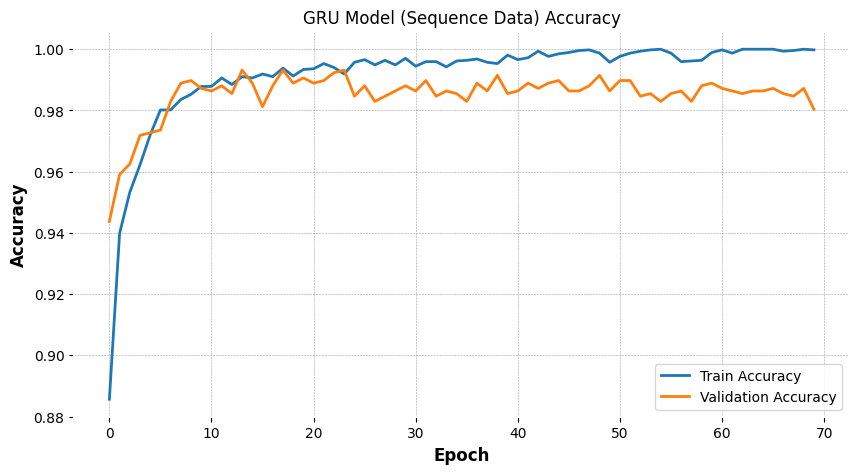

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt

# Giả sử bạn đã có dữ liệu sau khi chuẩn bị:
# X_seq_train, X_seq_test có dạng (samples, seq_length, n_features)
# y_train, y_test là nhãn mục tiêu (binary) với số mẫu khớp với X_seq_train, X_seq_test

# Ví dụ:
# X_seq_train, y_train = create_sequences(X_tech_aligned_full, y_aligned_full, seq_length)
# Sau khi căn chỉnh, đã chia thành tập train và test:
# (X_img_train, X_img_test, X_tech_train, X_tech_test, X_seq_train, X_seq_test, y_train, y_test) = train_test_split(..., shuffle=False)

# 1. Lấy số đặc trưng từ dữ liệu chuỗi:
n_features = X_seq_train.shape[2]
print("Số đặc trưng (n_features):", n_features)

# 2. Xây dựng mô hình GRU với dữ liệu chuỗi
seq_length = X_seq_train.shape[1]  # Độ dài sequence đã được tạo (ví dụ: 10)
gru_model = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(seq_length, n_features)),
    Dropout(0.2),
    GRU(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

gru_model.compile(optimizer=Adam(learning_rate=1e-3), 
                  loss="binary_crossentropy", 
                  metrics=["accuracy"])

gru_model.summary()

# 3. Huấn luyện và đánh giá mô hình GRU với MLflow
mlflow.set_experiment("GRU_Classification_Sequence_Crypto")
with mlflow.start_run():
    # Log các tham số
    mlflow.log_param("seq_length", seq_length)
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("train_size", X_seq_train.shape[0])
    mlflow.log_param("test_size", X_seq_test.shape[0])
    
    # Huấn luyện mô hình GRU với dữ liệu chuỗi
    history = gru_model.fit(
        X_seq_train, y_train, 
        epochs=70, 
        batch_size=32, 
        validation_data=(X_seq_test, y_test), 
        verbose=1
    )
    
    # Đánh giá mô hình trên tập test
    test_loss, test_accuracy = gru_model.evaluate(X_seq_test, y_test, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    # Dự đoán trên tập test
    y_pred_prob = gru_model.predict(X_seq_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    
    # Tạo và in báo cáo phân loại
    report = classification_report(y_test, y_pred_binary, zero_division=0)
    print("Classification Report:")
    print(report)
    mlflow.log_text(report, "classification_report.txt")
    
    # Tính và in ra Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    print("Confusion Matrix:")
    print(cm)
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    
    # Log mô hình vào MLflow
    mlflow.tensorflow.log_model(gru_model, artifact_path="gru_model")
    
    mlflow.end_run()

# 4. Vẽ đồ thị quá trình huấn luyện (accuracy)
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("GRU Model (Sequence Data) Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Evaluation GRU

In [65]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.tensorflow

# 1. Đánh giá mô hình GRU trên tập test sequence
test_loss, test_accuracy = gru_model.evaluate(X_seq_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 2. Dự đoán trên tập test
y_pred_prob = gru_model.predict(X_seq_test)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# 3. Tạo báo cáo phân loại
report = classification_report(y_test, y_pred_binary, zero_division=0)
print("Classification Report:")
print(report)

# 4. Tính và in ra Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# 5. Log các thông số đánh giá qua MLflow
mlflow.set_experiment("GRU_Classification_Sequence_Crypto_Evaluation")
with mlflow.start_run():
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    mlflow.end_run()


Test Loss: 0.0726
Test Accuracy: 0.9804
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       552
           1       0.97      0.99      0.98       621

    accuracy                           0.98      1173
   macro avg       0.98      0.98      0.98      1173
weighted avg       0.98      0.98      0.98      1173

Confusion Matrix:
[[535  17]
 [  6 615]]


# Using NAR

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7840 - loss: 0.4245 - val_accuracy: 0.9557 - val_loss: 0.1137
Epoch 2/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9410 - loss: 0.1338 - val_accuracy: 0.9702 - val_loss: 0.0824
Epoch 3/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.0993 - val_accuracy: 0.9795 - val_loss: 0.0607
Epoch 4/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.0720 - val_accuracy: 0.9847 - val_loss: 0.0461
Epoch 5/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0584 - val_accuracy: 0.9872 - val_loss: 0.0403
Epoch 6/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0551 - val_accuracy: 0.9881 - val_loss: 0.0343
Epoch 7/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0423 - val_accuracy: 0.9881 - val_loss: 0.0332
Epoch 8/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0398 - val_accuracy: 0.

2025/03/15 00:08:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       552
           1       1.00      1.00      1.00       621

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173

Confusion Matrix:
[[550   2]
 [  2 619]]


2025/03/15 00:08:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NAR model training and evaluation complete.


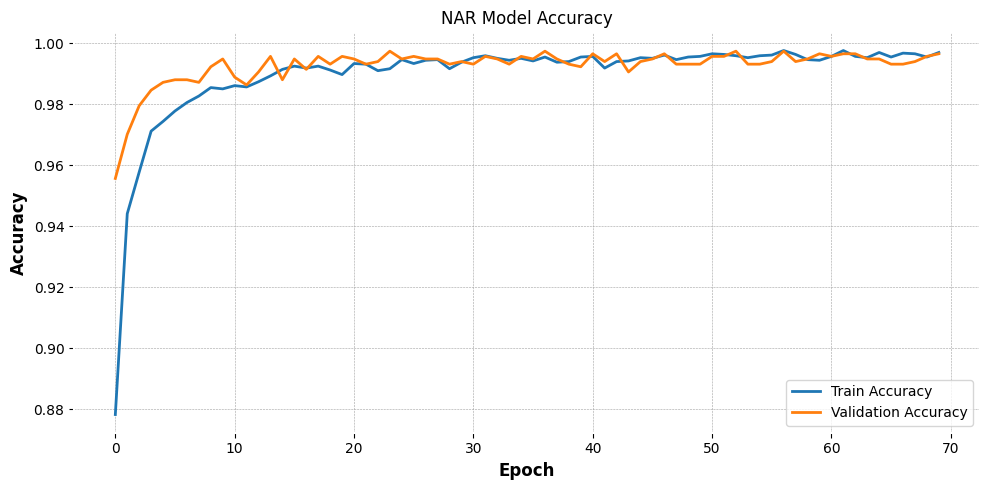

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt

# Giả sử bạn đã có các biến sau sau bước tiền xử lý:
# X_img_aligned, X_tech_aligned_full, y_aligned_full, X_seq, v.v.
# Và đã chia tập thành:
# (X_img_train, X_img_test, X_tech_train, X_tech_test, X_seq_train, X_seq_test, y_train, y_test)
# Ở đây, mô hình NAR chỉ sử dụng các đặc trưng kỹ thuật (X_tech_train, X_tech_test) và nhãn (y_train, y_test)

# Xây dựng mô hình NAR (Non-Autoregressive MLP) sử dụng đặc trưng kỹ thuật
nar_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_tech_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Biên dịch mô hình với optimizer Adam và loss binary_crossentropy cho phân lớp nhị phân
nar_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="binary_crossentropy", 
                  metrics=["accuracy"])

# In ra cấu trúc mô hình
nar_model.summary()

# Đặt tên experiment cho MLflow
mlflow.set_experiment("NAR_Classification_Crypto")

with mlflow.start_run():
    # Log các tham số tiền xử lý và cấu hình mô hình
    mlflow.log_param("model_type", "Non-Autoregressive MLP")
    mlflow.log_param("input_features", X_tech_train.shape[1])
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 70)
    mlflow.log_param("learning_rate", 0.001)
    
    # Huấn luyện mô hình
    history = nar_model.fit(
        X_tech_train, y_train, 
        epochs=70, 
        batch_size=32, 
        validation_data=(X_tech_test, y_test), 
        verbose=1
    )
    
    # Đánh giá mô hình trên tập test
    test_loss, test_accuracy = nar_model.evaluate(X_tech_test, y_test, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    # Dự đoán trên tập test
    y_pred_prob = nar_model.predict(X_tech_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    
    # Tạo và in báo cáo phân loại
    report = classification_report(y_test, y_pred_binary, zero_division=0)
    print("Classification Report:")
    print(report)
    mlflow.log_text(report, "classification_report.txt")
    
    # Tính và in ra Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    print("Confusion Matrix:")
    print(cm)
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    
    # Log mô hình vào MLflow
    mlflow.keras.log_model(nar_model, artifact_path="nar_model")
    
    # Vẽ đồ thị quá trình huấn luyện (accuracy)
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("NAR Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("nar_accuracy.png")
    mlflow.log_artifact("nar_accuracy.png")
    
    mlflow.end_run()

print("NAR model training and evaluation complete.")


# Evaluation NAR

In [67]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.tensorflow

# 1. Đánh giá mô hình NAR trên tập test
test_loss, test_accuracy = nar_model.evaluate(X_tech_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 2. Dự đoán trên tập test
y_pred_prob = nar_model.predict(X_tech_test)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# 3. Tạo báo cáo phân loại
report = classification_report(y_test, y_pred_binary, zero_division=0)
print("Classification Report:")
print(report)

# 4. Tính và in ra Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# 5. Log các kết quả đánh giá qua MLflow
mlflow.set_experiment("NAR_Classification_Crypto_Evaluation")
with mlflow.start_run():
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    mlflow.tensorflow.log_model(nar_model, artifact_path="nar_model")
    mlflow.end_run()


Test Loss: 0.0074
Test Accuracy: 0.9966
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


2025/03/15 00:10:31 INFO mlflow.tracking.fluent: Experiment with name 'NAR_Classification_Crypto_Evaluation' does not exist. Creating a new experiment.
2025/03/15 00:10:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       552
           1       1.00      1.00      1.00       621

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173

Confusion Matrix:
[[550   2]
 [  2 619]]


2025/03/15 00:10:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# FEATURE FUSION LAYER

In [68]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# --- Nhánh 1: MobileNetV2 (trích xuất đặc trưng ảnh) ---
input_img = Input(shape=(224, 224, 3), name="image_input")
# Sử dụng MobileNetV2 pretrained, loại bỏ phần phân loại
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_img)
base_model.trainable = False  # Đóng băng các trọng số
x1 = GlobalAveragePooling2D()(base_model.output)
x1 = Dense(128, activation="relu")(x1)
features_mobilenet = Dense(64, activation="relu", name="mobilenet_features")(x1)

# --- Nhánh 2: NAR (đặc trưng kỹ thuật) ---
# Giả sử các đặc trưng kỹ thuật đã được chuẩn hóa và có kích thước (n_features,)
input_tech = Input(shape=(X_tech_train.shape[1],), name="technical_input")
x2 = Dense(128, activation="relu")(input_tech)
x2 = Dropout(0.2)(x2)
features_nar = Dense(64, activation="relu", name="nar_features")(x2)

# --- Nhánh 3: GRU (đặc trưng chuỗi thời gian) ---
# Giả sử dữ liệu chuỗi có kích thước (timesteps, n_features_seq)
input_seq = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name="sequence_input")
x3 = GRU(64, return_sequences=True)(input_seq)
x3 = Dropout(0.2)(x3)
x3 = GRU(32, return_sequences=False)(x3)
features_gru = Dense(64, activation="relu", name="gru_features")(x3)

# --- Fusion Layer: Gộp các đặc trưng ---
merged = Concatenate(name="feature_fusion")([features_mobilenet, features_nar, features_gru])

# Các lớp fully-connected sau fusion
x = Dense(128, activation="relu")(merged)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid", name="output")(x)

# Xây dựng mô hình tổng hợp
model = Model(inputs=[input_img, input_tech, input_seq], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12208\1882797670.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_img)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,494,977 (9.52 MB)

 Trainable params: 236,993 (925.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# USING LIGHTGBM

pip install lightgbm optuna mlflow


In [70]:
import lightgbm as lgb
import optuna
import mlflow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Bước 1: Tạo Feature Extractor từ mô hình deep learning


In [71]:
from tensorflow.keras.models import Model

# Tạo model feature extractor lấy đầu ra của layer "feature_fusion"
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("feature_fusion").output)


- Bước 2: Trích xuất đặc trưng cho tập train và test


In [72]:
# Trích xuất đặc trưng cho tập train và test từ feature fusion layer
fused_features_train = feature_extractor.predict([X_img_train, X_tech_train, X_seq_train])
fused_features_test  = feature_extractor.predict([X_img_test,  X_tech_test,  X_seq_test])

print("Fused features train shape:", fused_features_train.shape)
print("Fused features test shape:", fused_features_test.shape)


147/147 ━━━━━━━━━━━━━━━━━━━━ 70s 455ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step
Fused features train shape: (4688, 192)
Fused features test shape: (1173, 192)


- Bước 3: Train LightGBM với các vector đặc trưng


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.lightgbm

# Giả sử nhãn của bạn là y_train và y_test (dạng 0/1)
# Tạo Dataset của LightGBM
lgb_train = lgb.Dataset(fused_features_train, label=y_train)
lgb_test  = lgb.Dataset(fused_features_test, label=y_test, reference=lgb_train)

# Đặt các tham số cho LightGBM
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'verbose': 1
}
num_round = 100

# Sử dụng MLflow để theo dõi LightGBM
mlflow.set_experiment("LightGBM_FeatureFusion_Classification")
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_param("num_round", num_round)
    
    # Huấn luyện LightGBM với callbacks cho early stopping và log evaluation
    bst = lgb.train(
        params, 
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_test], 
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]
    )
    
    # Dự đoán trên tập test
    y_pred_prob = bst.predict(fused_features_test, num_iteration=bst.best_iteration)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Tính toán các metric
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Accuracy:", acc)
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)
    
    # Log các metric qua MLflow
    mlflow.log_metric("accuracy", acc)
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    
    # Log mô hình LightGBM
    mlflow.lightgbm.log_model(bst, artifact_path="lgb_model")
    
    mlflow.end_run()


[LightGBM] [Info] Number of positive: 2387, number of negative: 2301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38920
[LightGBM] [Info] Number of data points in the train set: 4688, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509172 -> initscore=0.036694
[LightGBM] [Info] Start training from score 0.036694
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.620317	training's auc: 0.981869	valid_1's binary_logloss: 0.625984	valid_1's auc: 0.962686
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.633857	training's auc: 0.981077	valid_1's binary_logloss: 0.638104	valid_1's auc: 0.963733
Accuracy: 0.9036658141517476
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       552
   

2025/03/15 00:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [81]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.lightgbm

# Dự đoán xác suất trên tập test sử dụng mô hình LightGBM đã huấn luyện (bst)
y_pred_prob = bst.predict(fused_features_test, num_iteration=bst.best_iteration)
# Chuyển xác suất thành nhãn (binary) với ngưỡng 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Tính toán các metric
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# Log các kết quả đánh giá qua MLflow
mlflow.set_experiment("LightGBM_FeatureFusion_Classification_Evaluation")
with mlflow.start_run():
    mlflow.log_metric("accuracy", acc)
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    mlflow.end_run()


2025/03/15 00:39:43 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM_FeatureFusion_Classification_Evaluation' does not exist. Creating a new experiment.


Accuracy: 0.9036658141517476
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       552
           1       0.91      0.90      0.91       621

    accuracy                           0.90      1173
   macro avg       0.90      0.90      0.90      1173
weighted avg       0.90      0.90      0.90      1173

Confusion Matrix:
[[498  54]
 [ 59 562]]


# Visualize result

## Vẽ Biểu đồ Residual Plot
- Đánh giá độ lệch của dự đoán so với thực tế bằng residual plot. Residuals (sai số dự đoán) nên phân bố đều xung quanh trục 0.

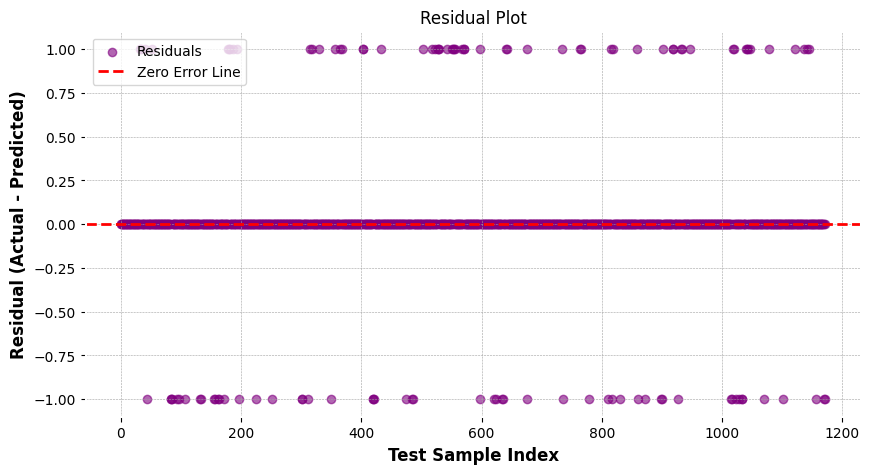

In [78]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, color="purple", alpha=0.6, label="Residuals")
plt.axhline(0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.show()


## Vẽ Biểu đồ KDE của Residuals
- Kiểm tra phân phối của sai số dự đoán để xem có bị lệch hoặc có mô hình đang thiên vị không.

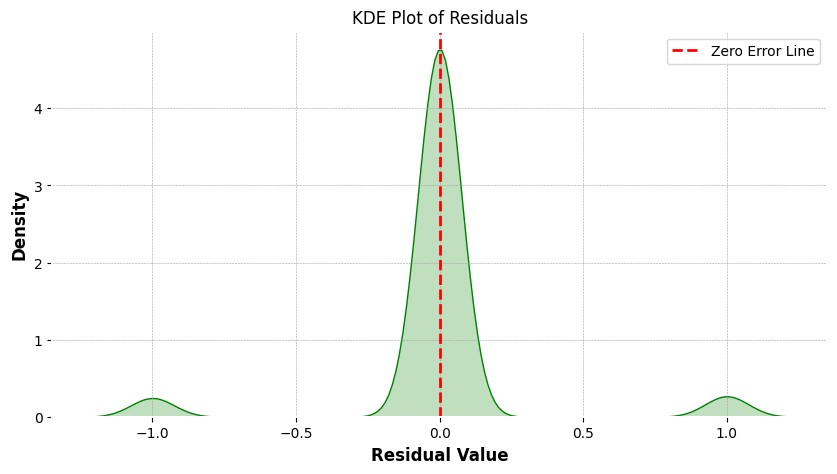

In [79]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(residuals, color="green", fill=True)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")
plt.title("KDE Plot of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## Vẽ Biểu đồ Error Distribution (Histogram)
- Kiểm tra xem sai số có phân bố chuẩn không.

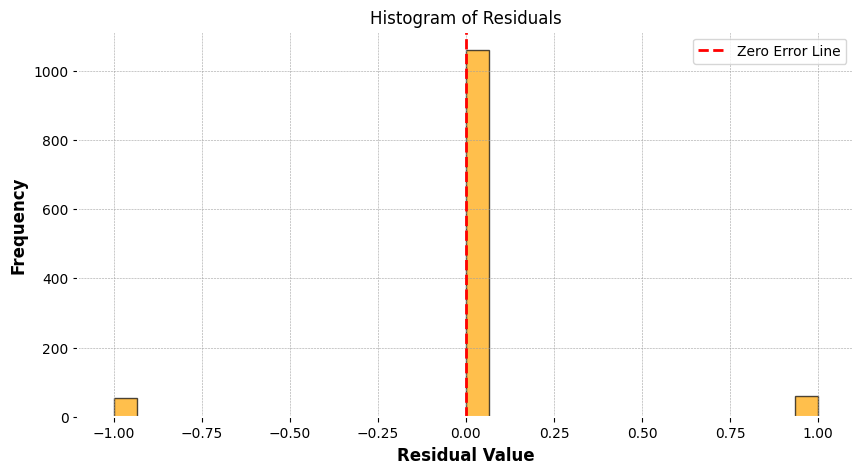

In [80]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color="orange", edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.legend()
plt.grid(True)
plt.show()


# Using XGBoost

In [82]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.xgboost

# --- Bước 1: Tạo DMatrix từ dữ liệu huấn luyện và test ---
dtrain = xgb.DMatrix(fused_features_train, label=y_train)
dtest  = xgb.DMatrix(fused_features_test, label=y_test)

# --- Bước 2: Đặt các tham số cho XGBoost ---
params = {
    'objective': 'binary:logistic',      # Bài toán phân lớp nhị phân
    'eval_metric': ['logloss', 'auc'],     # Metric đánh giá
    'eta': 0.01,                           # Learning rate
    'max_depth': 6,
    'verbosity': 1,
    'seed': 42
}
num_round = 100

# --- Bước 3: Huấn luyện mô hình XGBoost với early stopping ---
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=10)

# --- Bước 4: Dự đoán và đánh giá mô hình ---
y_pred_prob = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# --- Bước 5: Log các thông số đánh giá và mô hình qua MLflow ---
mlflow.set_experiment("XGBoost_FeatureFusion_Classification")
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_param("num_round", num_round)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    mlflow.xgboost.log_model(bst, artifact_path="xgb_model")
    mlflow.end_run()


[0]	train-logloss:0.68504	train-auc:0.98006	eval-logloss:0.68501	eval-auc:0.95435
[10]	train-logloss:0.61306	train-auc:0.98708	eval-logloss:0.62075	eval-auc:0.95881
[20]	train-logloss:0.55224	train-auc:0.98831	eval-logloss:0.56735	eval-auc:0.96087
[30]	train-logloss:0.50018	train-auc:0.98955	eval-logloss:0.52277	eval-auc:0.96105
[40]	train-logloss:0.45525	train-auc:0.99118	eval-logloss:0.48501	eval-auc:0.96277
[50]	train-logloss:0.41597	train-auc:0.99289	eval-logloss:0.45126	eval-auc:0.96540
[60]	train-logloss:0.38130	train-auc:0.99384	eval-logloss:0.42130	eval-auc:0.96665
[70]	train-logloss:0.35019	train-auc:0.99477	eval-logloss:0.39519	eval-auc:0.96821
[80]	train-logloss:0.32295	train-auc:0.99544	eval-logloss:0.37231	eval-auc:0.96933
[90]	train-logloss:0.29872	train-auc:0.99596	eval-logloss:0.35138	eval-auc:0.97167
[99]	train-logloss:0.27919	train-auc:0.99627	eval-logloss:0.33467	eval-auc:0.97262


2025/03/15 00:45:01 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_FeatureFusion_Classification' does not exist. Creating a new experiment.


Accuracy: 0.9104859335038363
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       552
           1       0.92      0.91      0.92       621

    accuracy                           0.91      1173
   macro avg       0.91      0.91      0.91      1173
weighted avg       0.91      0.91      0.91      1173

Confusion Matrix:
[[501  51]
 [ 54 567]]


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/15 00:45:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Evaluation

In [83]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.xgboost

# Giả sử fused_features_test và y_test đã được định nghĩa từ bước feature fusion

# Tạo DMatrix cho tập test
dtest = xgb.DMatrix(fused_features_test, label=y_test)

# Dự đoán xác suất trên tập test
y_pred_prob = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
# Chuyển đổi xác suất thành nhãn (binary) với ngưỡng 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Tính toán các metric
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# Log các kết quả đánh giá qua MLflow
mlflow.set_experiment("XGBoost_FeatureFusion_Classification_Evaluation")
with mlflow.start_run():
    mlflow.log_metric("accuracy", acc)
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_text(str(cm), "confusion_matrix.txt")
    mlflow.end_run()


2025/03/15 00:46:24 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_FeatureFusion_Classification_Evaluation' does not exist. Creating a new experiment.


Accuracy: 0.9104859335038363
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       552
           1       0.92      0.91      0.92       621

    accuracy                           0.91      1173
   macro avg       0.91      0.91      0.91      1173
weighted avg       0.91      0.91      0.91      1173

Confusion Matrix:
[[501  51]
 [ 54 567]]


# Final Prediction

## Step 1: Tạo hàm dự đoán (predict_signal)

In [147]:
# Giả sử bst là mô hình XGBoost đã huấn luyện với objective 'binary:logistic'
# new_features là vector đặc trưng mới có shape (1, 192)
new_features = np.random.random((1, 192))  # Thay bằng dữ liệu thực tế của bạn

# Tạo DMatrix cho mẫu mới
dmatrix = xgb.DMatrix(new_features)

# Dự đoán xác suất xu hướng tăng (binary: xác suất lớp 1)
# Giá trị prob nằm trong khoảng [0,1]; ta nhân 100 để có phần trăm.
prob = bst.predict(dmatrix)[0]  
indicator_percentage = prob * 100  # chuyển về phần trăm

def final_prediction(indicator_percentage, trend):
    """
    Chuyển đổi phần trăm chỉ báo và xu hướng thành tín hiệu cuối cùng.
    Với 5 tín hiệu: "Stop Buy", "Buy", "Hold", "Sell", "Stop Sell".
    """
    if indicator_percentage >= 75:
        # Nếu xu hướng tăng thì nên Stop Buy, nếu xu hướng giảm thì Stop Sell
        return "Stop Buy" if trend == "up" else "Stop Sell"
    elif indicator_percentage > 55 and indicator_percentage < 75:
        # Nếu xu hướng tăng thì Buy, nếu xu hướng giảm thì Hold
        return "Buy" if trend == "up" else "Hold"
    elif indicator_percentage >= 45 and indicator_percentage <= 55:
        # Nếu xu hướng tăng thì Buy, nếu xu hướng giảm thì Sell
        return "Buy" if trend == "up" else "Sell"
    else:
        # Với những trường hợp không đạt các ngưỡng trên, ta có thể dùng một giải pháp đơn giản (ví dụ: giữ)
        return "Hold"
    
# Áp dụng quy trình cho từng mẫu trong tập test
final_signals = []
for prob in y_pred_prob:
    indicator_percentage = prob * 100
    trend = "up" if prob > 0.5 else "down"
    signal = final_prediction(indicator_percentage, trend)
    final_signals.append(signal)

# In ra một số kết quả final prediction
for i, (p, sig) in enumerate(zip(y_pred_prob[:10], final_signals[:10])):
    print(f"Sample {i}: Probability: {p:.4f} ({p*100:.2f}%), Trend: {'up' if p > 0.5 else 'down'}, Final Signal: {sig}")
signal = final_prediction(indicator_percentage, trend)

print("Predicted probability (as percentage):", indicator_percentage)
print("Final prediction signal:", signal)

Sample 0: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 1: Probability: 0.8089 (80.89%), Trend: up, Final Signal: Stop Buy
Sample 2: Probability: 0.8089 (80.89%), Trend: up, Final Signal: Stop Buy
Sample 3: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 4: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 5: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 6: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 7: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 8: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Sample 9: Probability: 0.8148 (81.48%), Trend: up, Final Signal: Stop Buy
Predicted probability (as percentage): 78.53321
Final prediction signal: Stop Buy


## Step 2: Ghi log kết quả vào database

In [161]:
import psycopg2
from datetime import datetime, timezone
import json

def log_prediction_to_db(conn, features, signal, prob):
    """
    Lưu kết quả dự đoán vào bảng prediction_log.
    
    Parameters:
      conn      : Connection đối với PostgreSQL.
      features  : Mảng numpy hoặc list đặc trưng của mẫu (1 sample).
      signal    : Tín hiệu dự đoán (string), ví dụ "Buy", "Sell", "Hold", "Stop Buy", "Stop Sell".
      prob      : Xác suất dự đoán (float).
    """
    # Chuyển đổi features thành chuỗi JSON
    features_str = json.dumps(features.tolist())
    now_str = datetime.now(timezone.utc)  # Lấy thời gian hiện tại (UTC) có nhận biết múi giờ
    
    sql = """
    INSERT INTO cryptocurrency_prediction.prediction_log (timestamp, features, signal, prob_sell, prob_buy)
    VALUES (%s, %s, %s, %s, %s)
    """
    with conn.cursor() as cur:
        cur.execute(sql, (now_str, features_str, signal, float(1 - prob), float(prob)))
    conn.commit()

- Khi dự đoán xong, bạn gọi hàm này để ghi log:

In [162]:
# Kết nối đến PostgreSQL
conn = psycopg2.connect(
    dbname="cryptocurrency",     # Tên cơ sở dữ liệu
    user="postgres",             # Tên người dùng
    password="admin",            # Mật khẩu
    host="localhost",            # Địa chỉ host
    port="5432"                  # Cổng (mặc định là 5432)
)

# Ghi log dự đoán vào database (sử dụng new_features[0] vì new_features có shape (1, n_features))
log_prediction_to_db(conn, new_features[0], signal, prob)
print("Prediction logged to database.")

Prediction logged to database.


# Xác định Vùng Kháng Cự và Hỗ Trợ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tính các đường trung bình động
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA50'] = df['close'].rolling(window=50).mean()
df['MA200'] = df['close'].rolling(window=200).mean()

# Vẽ biểu đồ giá và các đường MA
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label="Close Price", color='blue')
plt.plot(df['timestamp'], df['MA20'], label="MA20 (Support/Resistance)", linestyle='dotted', color='red')
plt.plot(df['timestamp'], df['MA50'], label="MA50", linestyle='dashed', color='green')
plt.plot(df['timestamp'], df['MA200'], label="MA200", linestyle='solid', color='black')
plt.legend()
plt.title("Vùng Kháng Cự/Hỗ Trợ Dựa trên MA")
plt.show()


# Dùng Pivot Points để Xác định Mức Giá Quan Trọng

In [ ]:
df['PP'] = (df['high'] + df['low'] + df['close']) / 3
df['R1'] = (2 * df['PP']) - df['low']
df['S1'] = (2 * df['PP']) - df['high']

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label="Close Price", color='blue')
plt.plot(df['timestamp'], df['PP'], label="Pivot Point", linestyle='dotted', color='black')
plt.plot(df['timestamp'], df['R1'], label="Resistance 1", linestyle='dashed', color='red')
plt.plot(df['timestamp'], df['S1'], label="Support 1", linestyle='dashed', color='green')
plt.legend()
plt.title("Pivot Points - Vùng Kháng Cự & Hỗ Trợ")
plt.show()


# Xác định Vùng Hỗ Trợ/Kháng Cự bằng ATR

In [ ]:
df['ATR'] = df['high'].rolling(14).max() - df['low'].rolling(14).min()
df['Resistance'] = df['close'] + (1.5 * df['ATR'])
df['Support'] = df['close'] - (1.5 * df['ATR'])

# Vẽ biểu đồ hỗ trợ/kháng cự
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label="Close Price", color='blue')
plt.plot(df['timestamp'], df['Resistance'], label="Resistance (ATR)", linestyle='dashed', color='red')
plt.plot(df['timestamp'], df['Support'], label="Support (ATR)", linestyle='dashed', color='green')
plt.legend()
plt.title("Xác định Vùng Hỗ Trợ/Kháng Cự bằng ATR")
plt.show()


# Áp dụng vào Chiến lược Giao dịch


In [ ]:
def generate_trading_signal_with_support_resistance(model, recent_data, scaler, support, resistance, threshold=0.01):
    # Dự đoán giá tương lai
    recent_data = np.expand_dims(recent_data, axis=0)
    predicted_price = model.predict(recent_data)

    # Chuyển về giá thực
    predicted_price_actual = scaler.inverse_transform(
        np.hstack((np.zeros((predicted_price.shape[0], len(numeric_columns) - 1)), predicted_price))
    )[:, -1]

    # Giá hiện tại
    current_price_actual = scaler.inverse_transform(
        np.hstack((np.zeros((1, len(numeric_columns) - 1)), np.array([[recent_data[0][-1][3]]])))
    )[:, -1][0]

    # Tín hiệu dựa trên hỗ trợ & kháng cự
    if predicted_price_actual[0] > resistance:
        return "SELL"
    elif predicted_price_actual[0] < support:
        return "BUY"
    else:
        return "HOLD"
